## Rede Neural MLP

In [1]:
# Importando os módulos necessários para o processamento dos dados
import numpy   as np
import pandas  as pd

# Módulos necessários para visualização dos dados
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Importando os módulos auxiliares

from sklearn.model_selection import train_test_split # Divisão de conjunto de treinamento e teste
from sklearn.model_selection import cross_validate # Validação cruzada do modelo
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV # Busca pelos melhores hiperparâmetros
from sklearn.externals import joblib # Necessário para salvar os modelos treinados em arquivos externos
from imblearn.over_sampling import SMOTE # Balanceamento de classes
from sklearn.preprocessing import LabelEncoder

# Métricas de avaliação

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import itertools

# Permite que o interpretador de latex (que aceita unicode) seja usado nos textos

matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['text.latex.unicode'] = False

# Função auxiliar para plotar a matriz de confusão. 
# Retirada de: 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')
    
def gerar_dataset_balanceado(train_data, 
                             train_target, 
                             test_data, 
                             test_target):
    
    sm = SMOTE(random_state=0, ratio='minority')
    
    encoders = list()
    
    for i in range(2): # Repete duas vezes o loop: um para o conjunto de treino e outro para o de teste
        if i == 0:
            data = train_data
            target = train_target
        elif i == 1:
            data = test_data
            target = test_target
    
        for feature in train_data.select_dtypes('object').columns:
            lb = LabelEncoder()

            lb.fit(data[feature])
            data[feature] = list(lb.transform(data[feature]))
            data[feature] = data[feature].astype('object')

            encoders.append(lb)

        data_b, target_b = sm.fit_sample(data, target)
    #     train_data_b = train_data_b.astype('int64')

    #     train_data_b = pd.DataFrame(train_data_b, columns=pd.get_dummies(train_data).columns)
        data_b = pd.DataFrame(data_b, columns=data.columns)
        data_b['earnings'] = target_b
        data_b = data_b.sample(frac=1) # Embaralha os registros

        target_b = data_b['earnings']
        data_b.drop(columns='earnings', inplace=True)

        for idx, feature in enumerate(data.select_dtypes('object').columns):

            data[feature] = encoders[idx].inverse_transform(list(data[feature]))

            data_b[feature] = data_b[feature].astype('int64')
            data_b[feature] = encoders[idx].inverse_transform(list(data_b[feature]))
        
        if i == 0:
            train_data_b = data_b
            train_target_b = target_b
        elif i == 1:
            test_data_b = data_b
            test_target_b = target_b
    
#     test_data_b, test_target_b = sm.fit_sample(pd.get_dummies(test_data), test_target)

#     test_data_b = pd.DataFrame(test_data_b, columns=pd.get_dummies(test_data).columns)
#     test_data_b['earnings'] = test_target_b
#     test_data_b = test_data_b.sample(frac=1) # Embaralha os registros
    
#     test_target_b = test_data_b['earnings']
#     test_data_b.drop(columns='earnings', inplace=True)
    
    return train_data_b, train_target_b, test_data_b, test_target_b

def exibir_resultados_finais(clf, 
                             test_data, 
                             test_target, 
                             id_abordagem, 
                             str_balanceamento, 
                             path_arquivos,
                             tipo_classificador,
                             fracao_dataset=0.1,
                             salvar_resultados=False):
    
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['text.latex.unicode'] = False
    
    # Classificando o conjunto de teste
    
    if tipo_classificador != 'mlp':

        predicoes = clf.predict(test_data)
        
    else:
        
        predicoes_proba = clf.predict(test_data)
        predicoes = np.zeros(predicoes_proba[:,0].shape[0])
        for i in range(0,predicoes_proba[:,0].shape[0]):
            predicoes[i] = 1 if (predicoes_proba[:,0][i] > 0.5) else 0
        

    if tipo_classificador == 'arvore':
    
        # Salvando a árvore treinada graficamente

        export_graphviz(clf, 
                        out_file=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-dataset-'+str(int(fracao_dataset*100))+'pct.dot', 
                        feature_names=test_data.columns,  
                        class_names=['Less than or equal to', 'More than'],  
                        filled=True, rounded=True,  
                        special_characters=True)  

    # Avaliando o desempenho

    # Matriz de confusão

    cfs_mtx = confusion_matrix(test_target, predicoes)
    plt.figure(figsize=(20,10))
    sns.set(font_scale=2)
    ax = sns.heatmap(cfs_mtx, 
                     xticklabels=['$\leq50$K', '$>50$K'], 
                     yticklabels=['$\leq50$K', '$>50$K'], 
                     annot=cfs_mtx,
                     fmt='d',
                     cbar=None)

    ax.set_xlabel('Predito', labelpad=20, fontsize=30)
    ax.set_ylabel('Real', labelpad=20, fontsize=30)
    ax.set_title('Matriz de Confusão')
    
    acc = accuracy_score(test_target, predicoes)
    pre = precision_score(test_target, predicoes)
    rec = recall_score(test_target, predicoes)
    f1 = f1_score(test_target, predicoes)
    
    if tipo_classificador in ['svm-rbf','svm-linear']:
        predicoes = clf.decision_function(test_data)
    elif tipo_classificador in ['arvore','naive-bayes','logit','knn','rf']:
        predicoes = clf.predict_proba(test_data)[:,1]
    elif tipo_classificador in ['mlp']:
        predicoes = predicoes_proba
    
    roc_auc = roc_auc_score(test_target, predicoes)
    prc_auc = average_precision_score(test_target, predicoes)

    print('Acurácia: %.3f %%' % (acc*100))
    print('Precisão: %.3f %%' % (pre*100))
    print('Recall: %.3f %%' % (rec*100))
    print('F1 score: %3f %%' % (f1*100))
    print('ROC AUC: %.3f %%' % (roc_auc*100))
    print('PRC AUC: %.3f %%' % (prc_auc*100))

    # plot_confusion_matrix(cfs_mtx, ['<=50K', '>50K'], normalize=False)
    
    if salvar_resultados:
        if tipo_classificador == 'arvore':
            path_graficos = 'Classificadores/Arvores-decisao/'
        elif tipo_classificador in ['svm-linear', 'svm-rbf']:
            path_graficos = 'Classificadores/SVM/'
        elif tipo_classificador == 'naive-bayes':
            path_graficos = 'Classificadores/Naive-bayes/'
        elif tipo_classificador == 'logit':
            path_graficos = 'Classificadores/Regressao-logistica/'
        elif tipo_classificador == 'knn':
            path_graficos = 'Classificadores/kNN/'
        elif tipo_classificador == 'rf':
            path_graficos = 'Classificadores/Random-forest/'
        elif tipo_classificador == 'mlp':
            path_graficos = 'Classificadores/Redes-neurais-MLP-2/teste/'
            
        joblib.dump(predicoes,
                    path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-predicoes.pkl')    
        
        filename = path_graficos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-matriz-confusao.png'
        plt.savefig(filename)
        
        d = {'Acuracia': acc, 
             'Precisao': pre, 
             'Recall': rec, 
             'F1': f1,
             'ROC AUC': roc_auc, 
             'PRC AUC': prc_auc}
        
        temp = pd.Series(data=d).to_csv(path=path_arquivos+tipo_classificador+'-final-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-medidas.csv', sep=',')
        
        
    plt.show()
    
    matplotlib.rcParams['text.usetex'] = False
    matplotlib.rcParams['text.latex.unicode'] = False

def gerarLinhaTabelaResultadosCVRedeNeural(metricas, 
                                           n_splits,
                                           train_scores_acc, 
                                           train_scores_pre,
                                           train_scores_rec,
                                           train_scores_f1,
                                           train_scores_roc,
                                           val_scores_acc,
                                           val_scores_pre,
                                           val_scores_rec,
                                           val_scores_f1,
                                           val_scores_roc):
    
    ''' Essa função cria uma linha contendo os resultados da validação cruzada de uma determinada configuração
        de rede neural para cada métrica passada. No momento, as métricas aceitas são acurácia, precisão, recall
        f1 score e roc auc. Todas elas devem ser passadas na lista metricas. Ao término da função, os valores
        da linha da tabela são retornados, permitindo que tal linha seja adicionada a uma tabela externa. '''

    # Tabela com resultados de treino

    tb_train = pd.DataFrame(columns=['split'+str(i)+'_train_'+metrica for i in list(range(0,n_splits)) for metrica in metricas])

    idx_vetores = -1
    for idx2,col in enumerate(tb_train.columns):
        if idx2%5 == 0:
            idx_vetores += 1
            vetor = train_scores_acc
        elif idx2%5 == 1:
            vetor = train_scores_pre
        elif idx2%5 == 2:
            vetor = train_scores_rec
        elif idx2%5 == 3:
            vetor = train_scores_f1
        elif idx2%5 == 4:
            vetor = train_scores_roc

        tb_train.loc[0,col] = vetor[idx_vetores]

    # Tabela com resultados de validação

    tb_val = pd.DataFrame(columns=['split'+str(i)+'_test_'+metrica for i in list(range(0,n_splits)) for metrica in metricas])

    idx_vetores = -1
    for idx2,col in enumerate(tb_val.columns):
        if idx2%5 == 0:
            idx_vetores += 1
            vetor = val_scores_acc
        elif idx2%5 == 1:
            vetor = val_scores_pre
        elif idx2%5 == 2:
            vetor = val_scores_rec
        elif idx2%5 == 3:
            vetor = val_scores_f1
        elif idx2%5 == 4:
            vetor = val_scores_roc

        tb_val.loc[0,col] = vetor[idx_vetores]

    # Concatenação das duas tabelas

    tb = pd.concat([tb_train, tb_val], axis=1)
    
    return tb.values # Retorna somente os valores das linhas, e não a tabela criada.


# ATENÇÃO!!! Escolher corretamente qual a fração do dataset que está sendo utilizada

fracao_dataset = 0.1

In [2]:
# Importando os arquivos com os datasets pré-processados

path_arquivos = 'Data/'

data_pre_proc_1 = pd.read_csv(path_arquivos+'data-pre-proc-1.csv')
data_pre_proc_2 = pd.read_csv(path_arquivos+'data-pre-proc-2.csv')
data_pre_proc_3 = pd.read_csv(path_arquivos+'data-pre-proc-3.csv')
data_pre_proc_4 = pd.read_csv(path_arquivos+'data-pre-proc-4.csv')

# Descartando a primeira coluna, que é só identificador do registro

data_pre_proc_1 = data_pre_proc_1.iloc[:,1::]
data_pre_proc_2 = data_pre_proc_2.iloc[:,1::]
data_pre_proc_3 = data_pre_proc_3.iloc[:,1::]
data_pre_proc_4 = data_pre_proc_4.iloc[:,1::]

# Separando o target e dividindo os conjuntos de treino e teste para cada dataset

# Dataset 1

target_1 = data_pre_proc_1['earnings']
data_pre_proc_1.drop(columns='earnings', inplace=True)

train_data_1, test_data_1, train_target_1, test_target_1 = train_test_split(
    data_pre_proc_1, target_1, test_size=0.33, random_state=0)

train_data_b_1, train_target_b_1, test_data_b_1, test_target_b_1 = gerar_dataset_balanceado(
    train_data_1, train_target_1, test_data_1, test_target_1)

# Dataset 2

target_2 = data_pre_proc_2['earnings']
data_pre_proc_2.drop(columns='earnings', inplace=True)

train_data_2, test_data_2, train_target_2, test_target_2 = train_test_split(
    data_pre_proc_2, target_2, test_size=0.33, random_state=0)

train_data_b_2, train_target_b_2, test_data_b_2, test_target_b_2 = gerar_dataset_balanceado(
    train_data_2, train_target_2, test_data_2, test_target_2)
    
# Dataset 3
    
target_3 = data_pre_proc_3['earnings']
data_pre_proc_3.drop(columns='earnings', inplace=True)

train_data_3, test_data_3, train_target_3, test_target_3 = train_test_split(
    data_pre_proc_3, target_3, test_size=0.33, random_state=0)

train_data_b_3, train_target_b_3, test_data_b_3, test_target_b_3 = gerar_dataset_balanceado(
    train_data_3, train_target_3, test_data_3, test_target_3)
    
# Dataset 4    

target_4 = data_pre_proc_4['earnings']
data_pre_proc_4.drop(columns='earnings', inplace=True)

train_data_4, test_data_4, train_target_4, test_target_4 = train_test_split(
    data_pre_proc_4, target_4, test_size=0.33, random_state=0)

train_data_b_4, train_target_b_4, test_data_b_4, test_target_b_4 = gerar_dataset_balanceado(
    train_data_4, train_target_4, test_data_4, test_target_4)

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

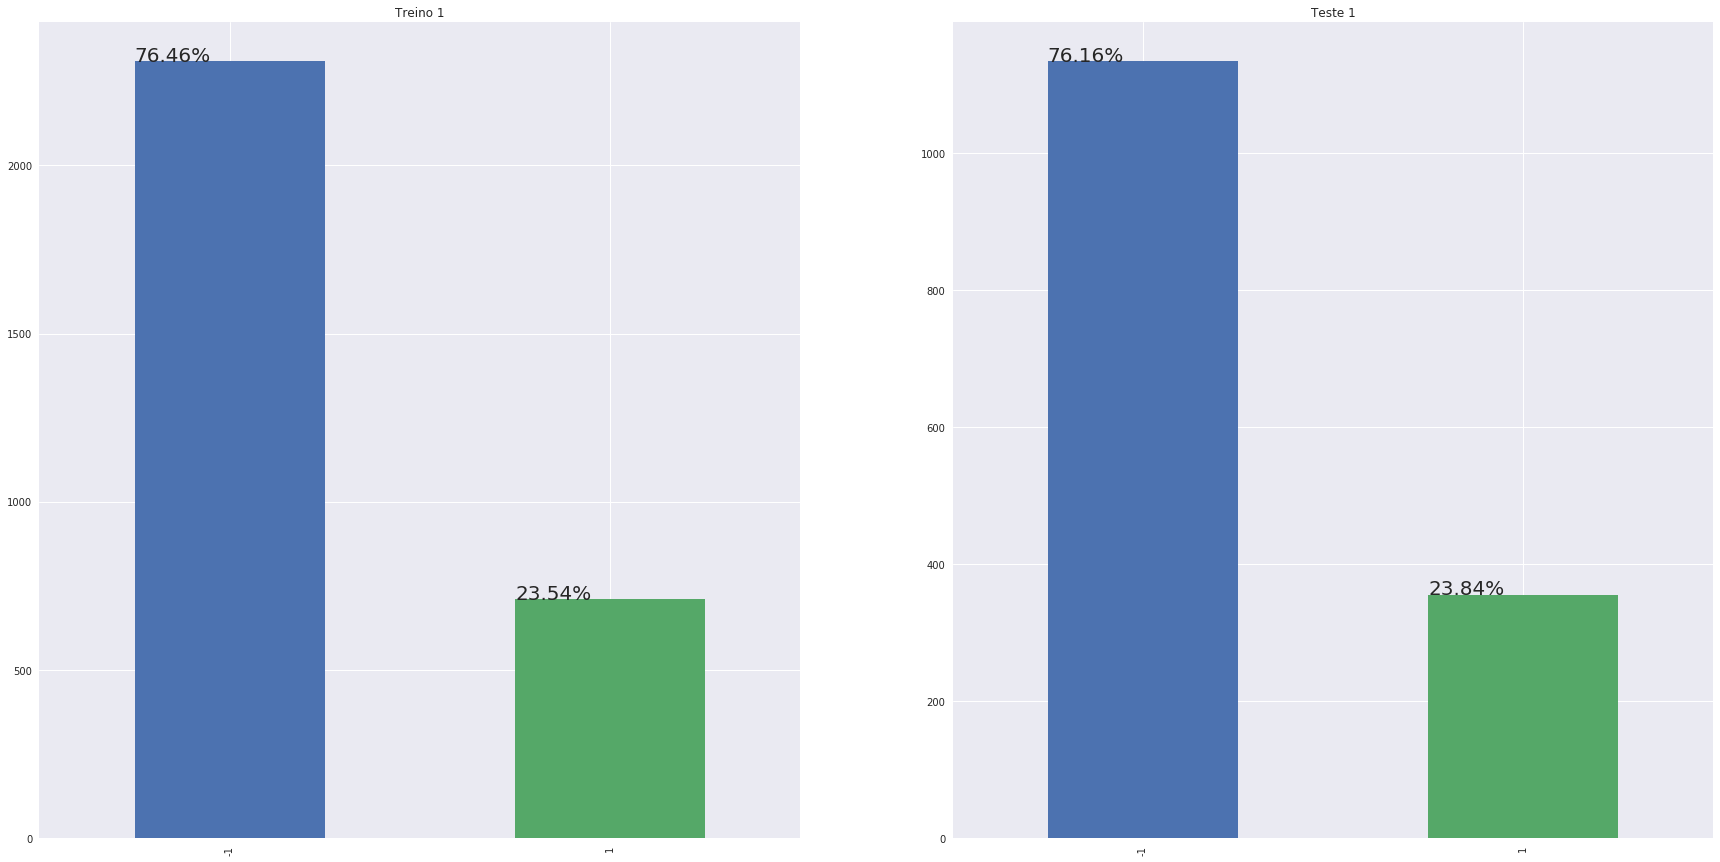

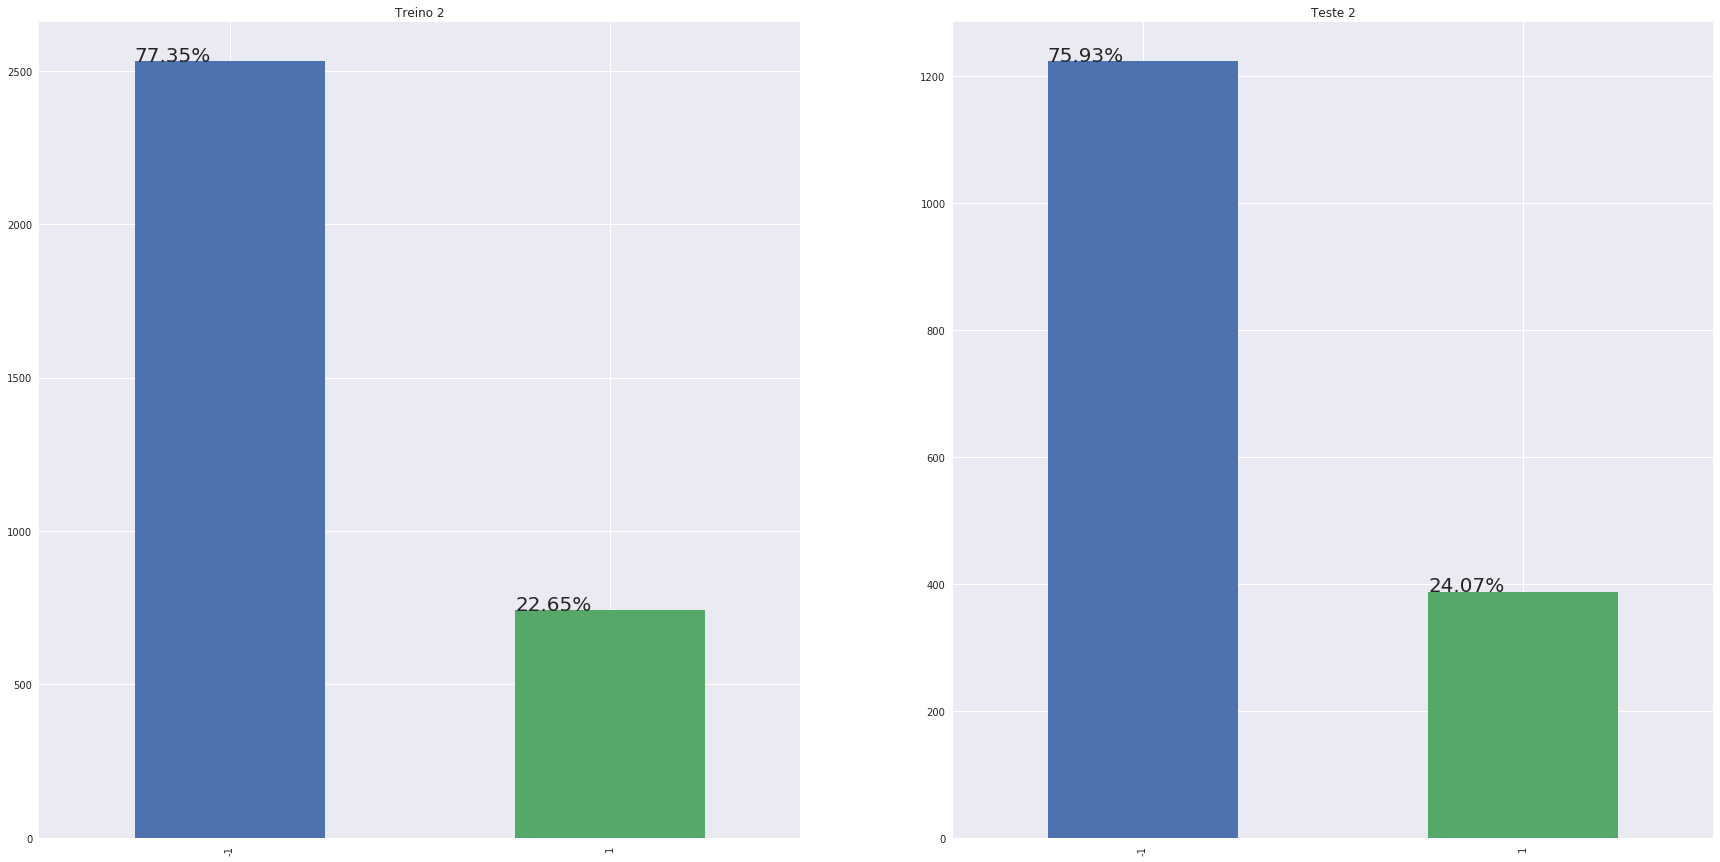

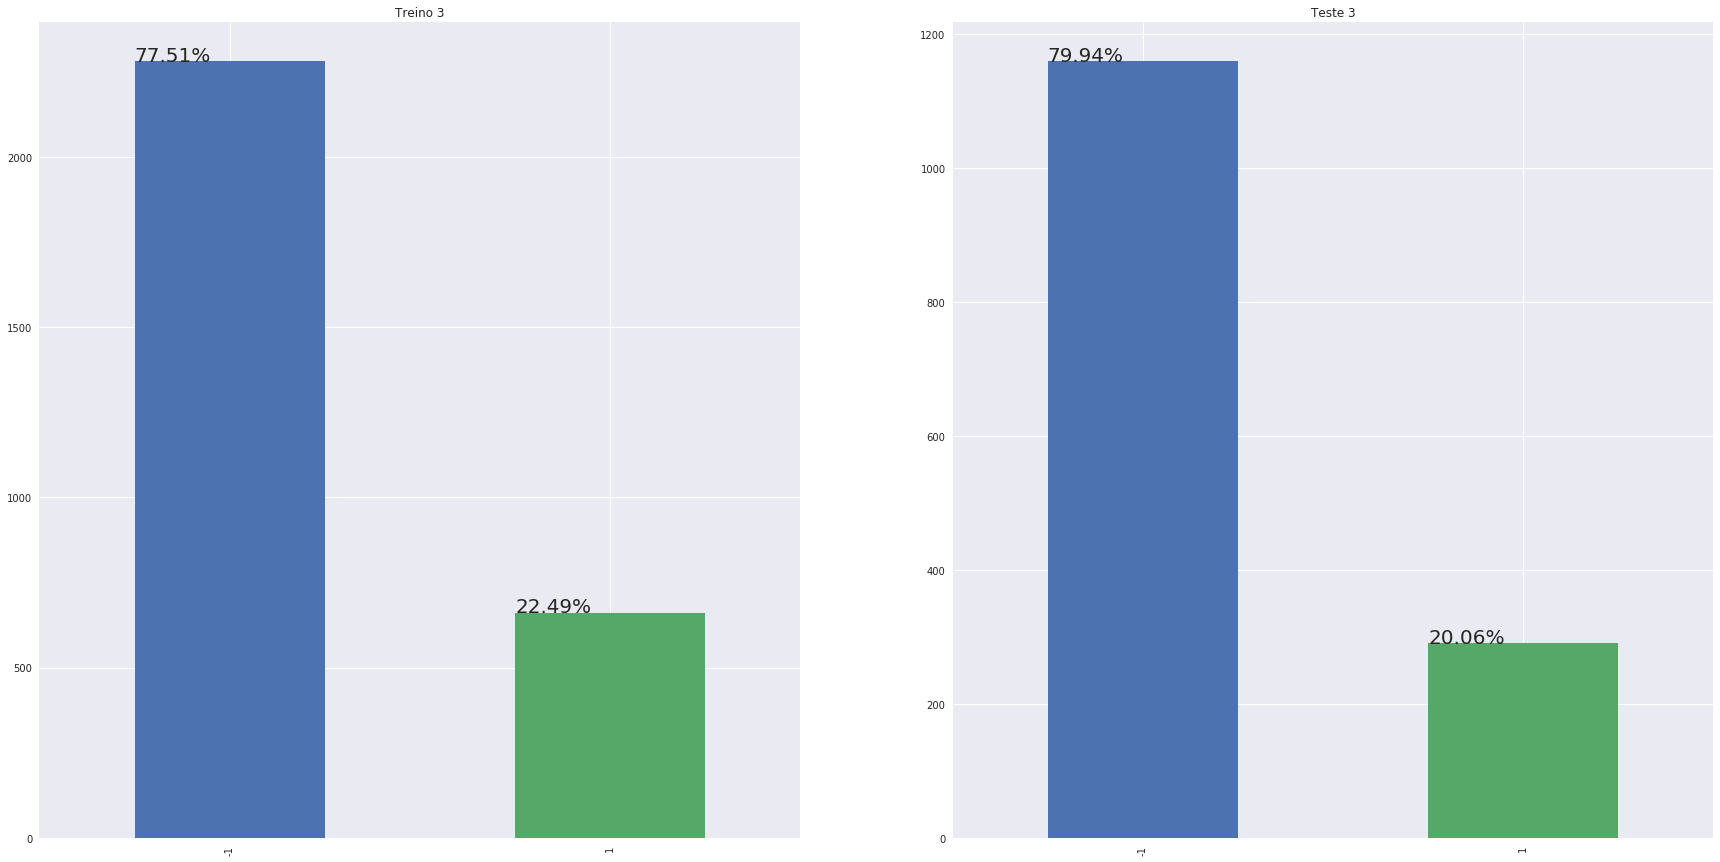

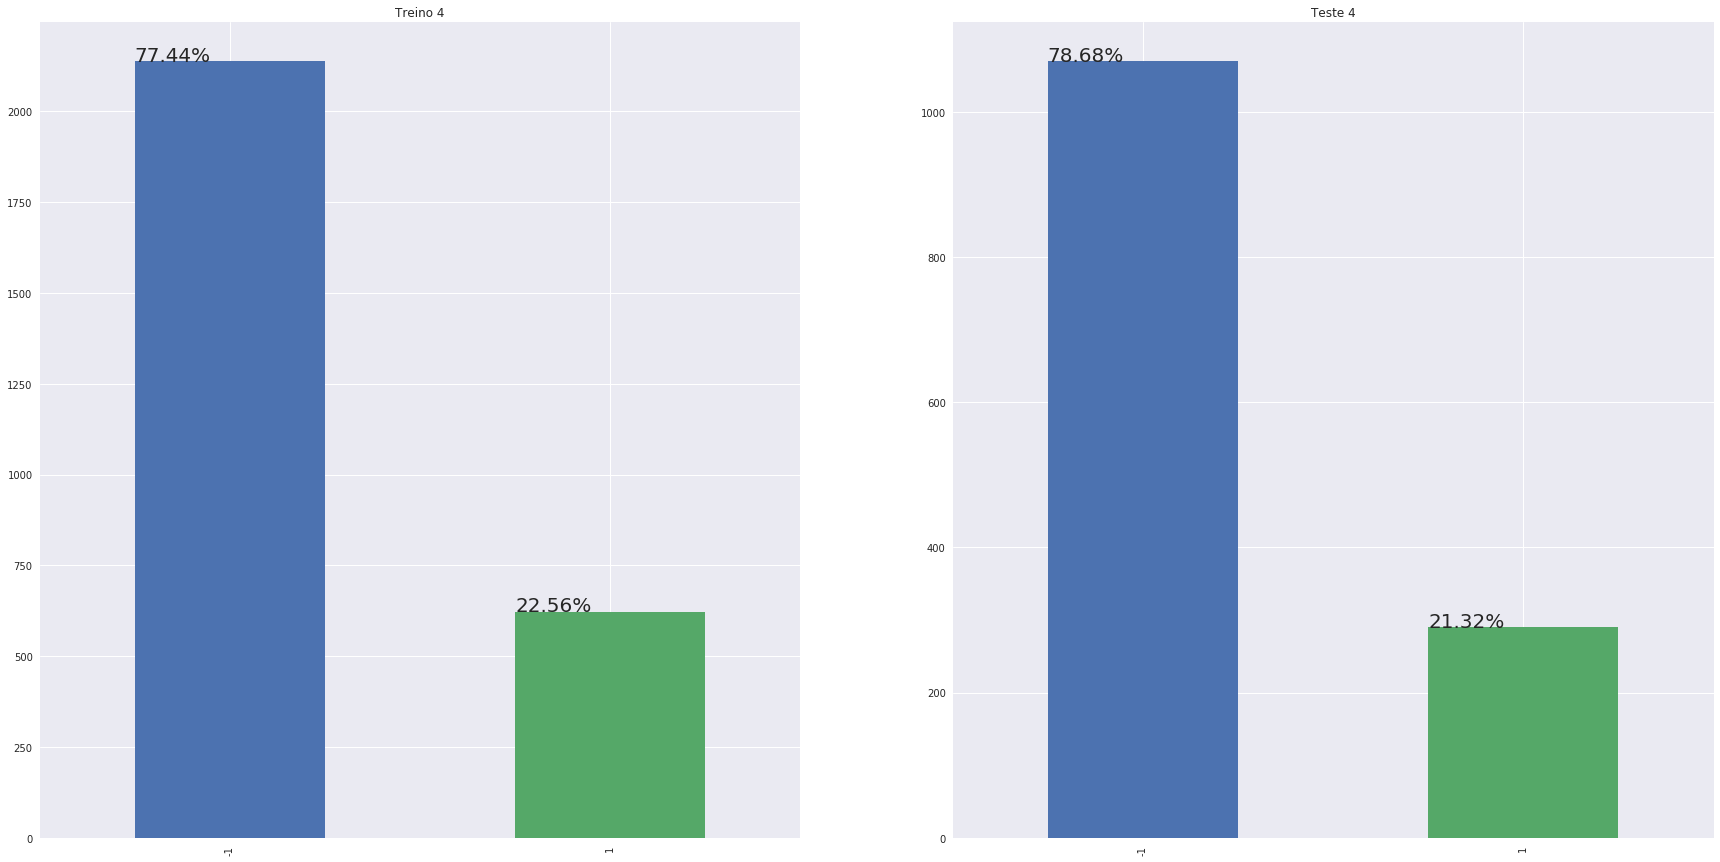

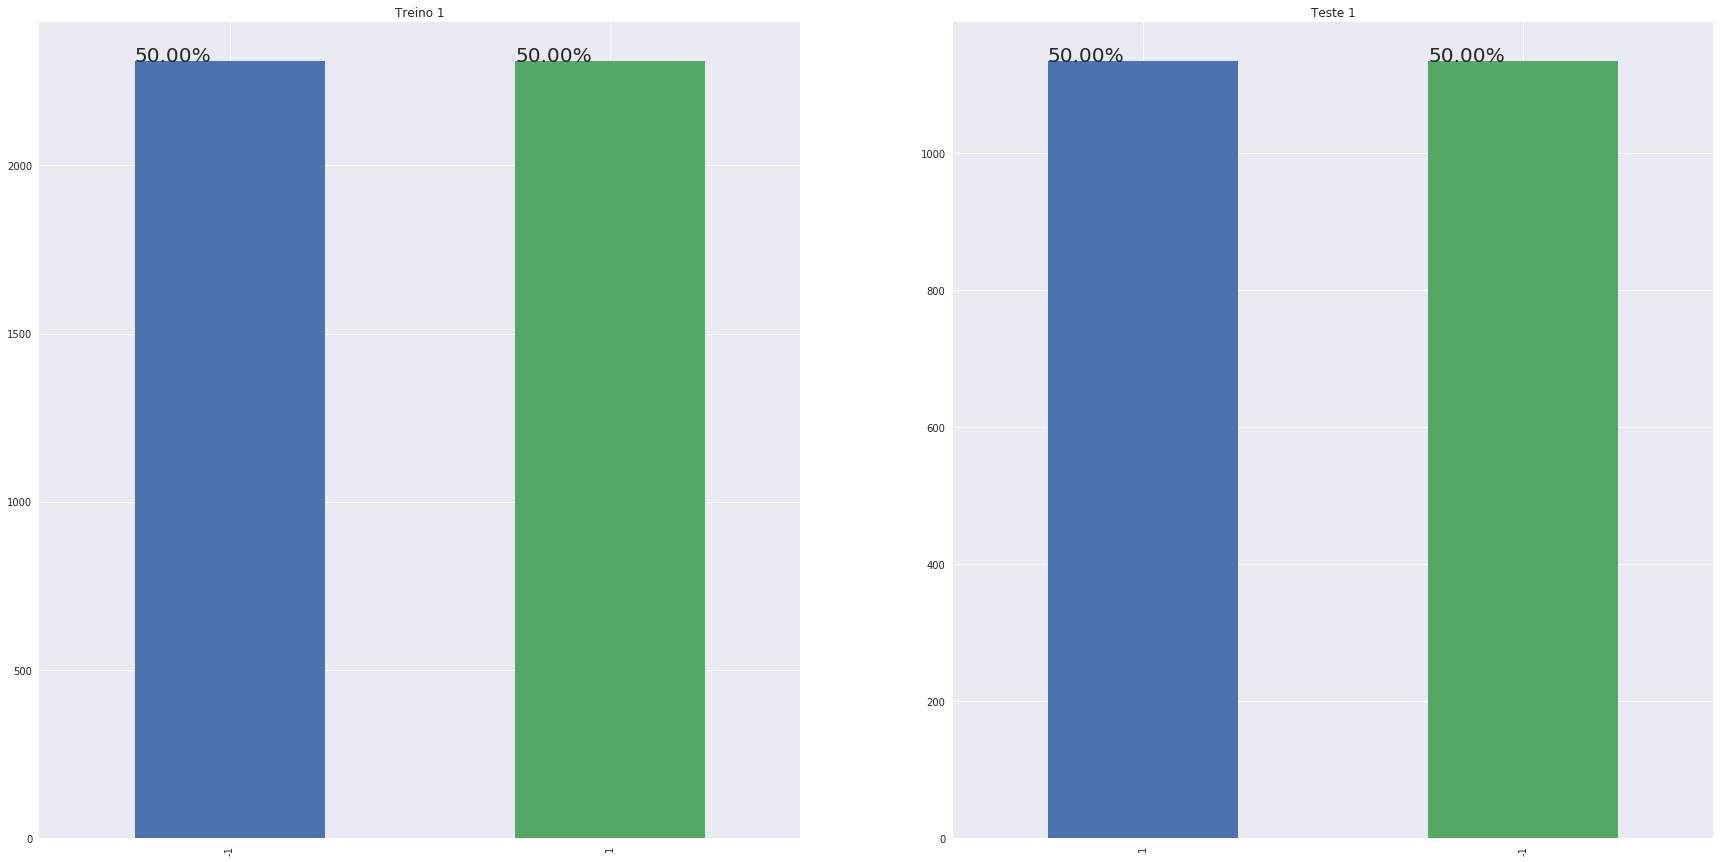

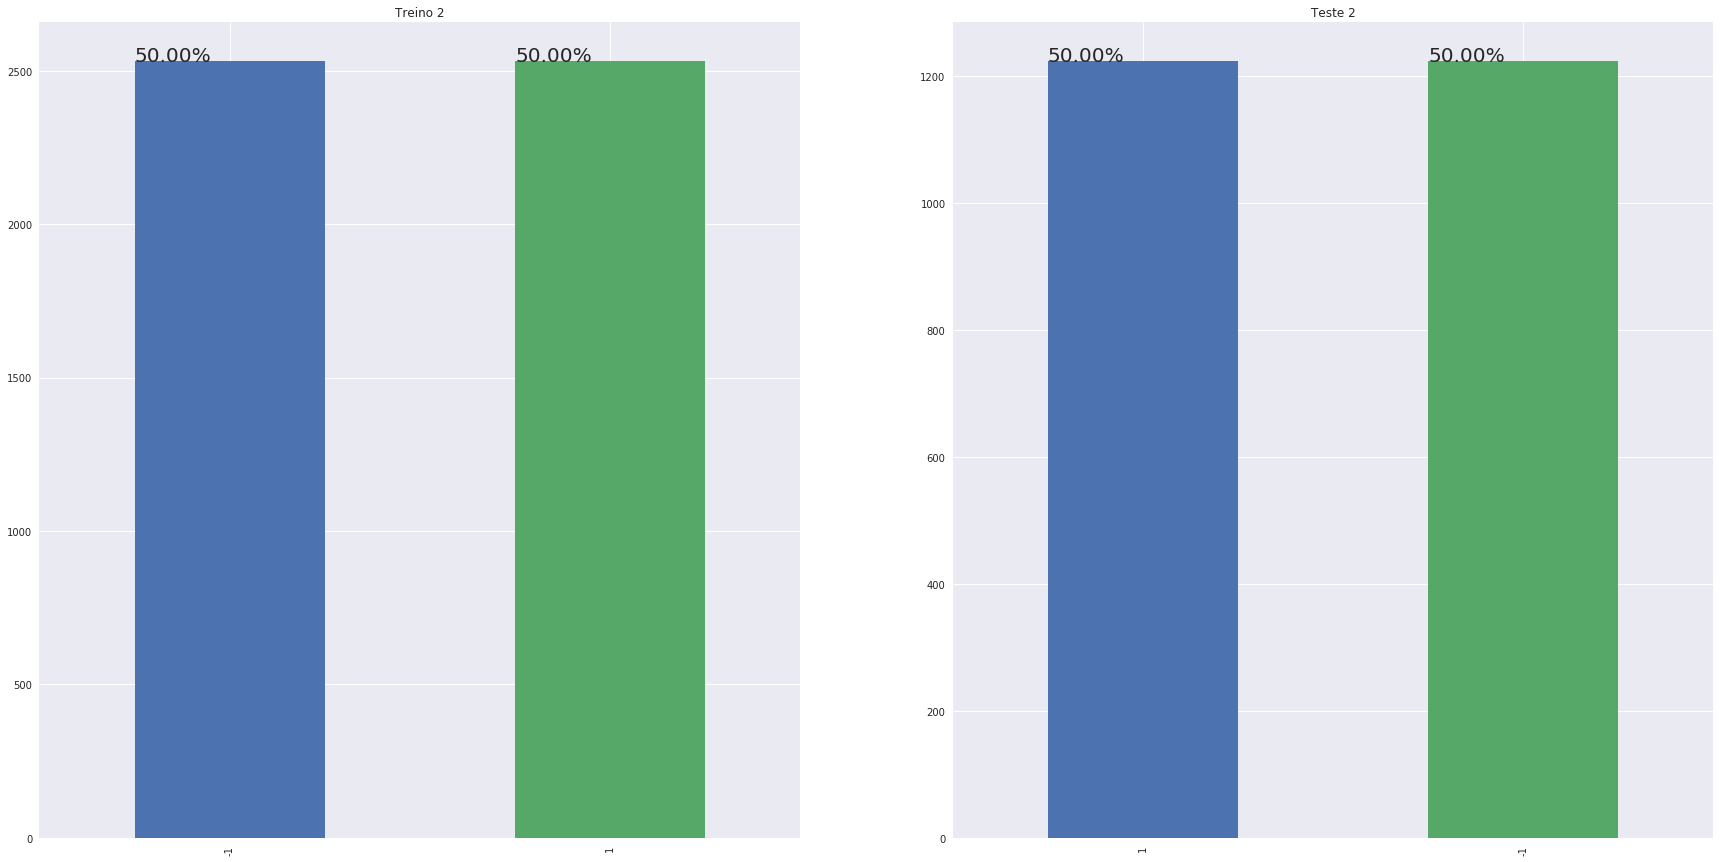

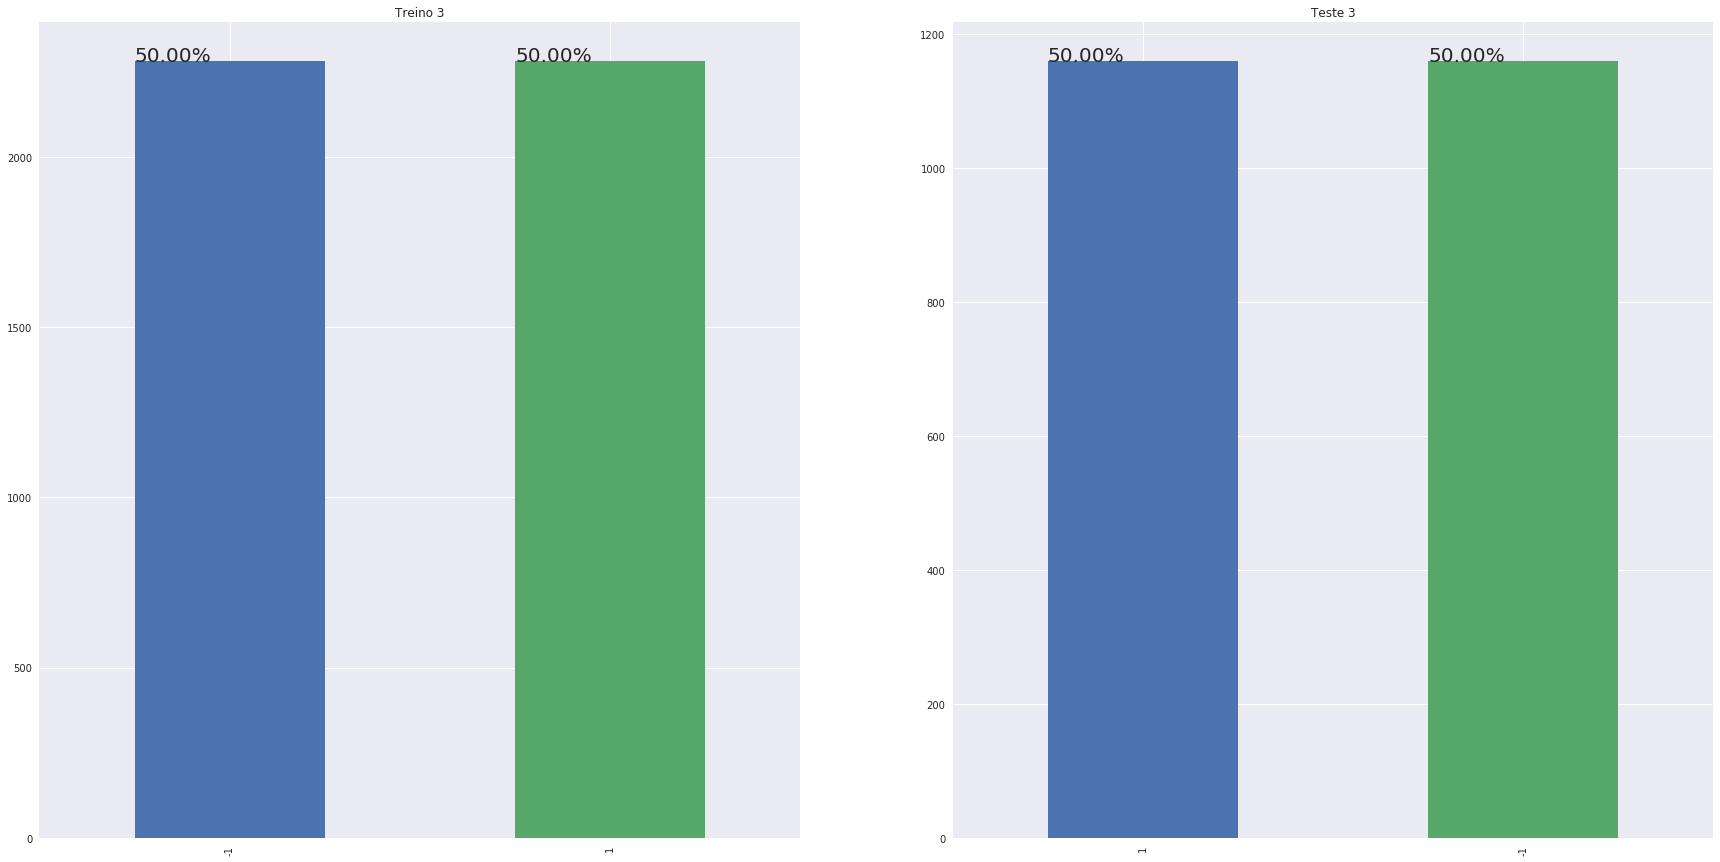

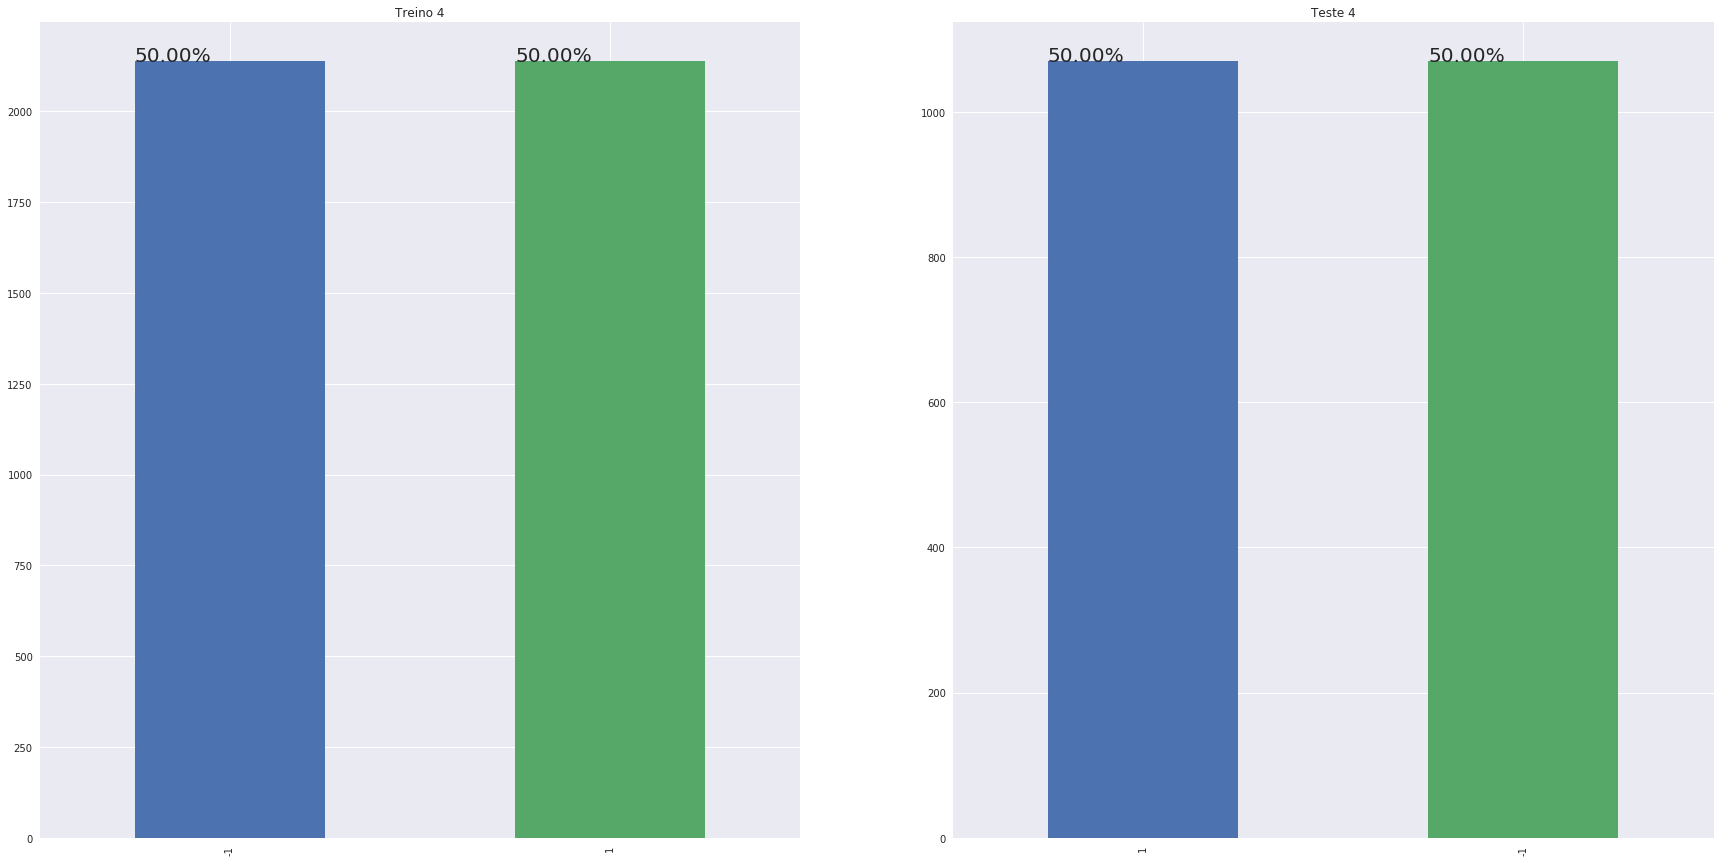

In [3]:
# Checando a distribuição dos targets em cada conjunto (treino e teste) de cada abordagem

sns.set(style='darkgrid')
temp_train = [train_target_1, train_target_2, train_target_3, train_target_4]
temp_test = [test_target_1, test_target_2, test_target_3, test_target_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

temp_train_b = [train_target_b_1, train_target_b_2, train_target_b_3, train_target_b_4]
temp_test_b = [test_target_b_1, test_target_b_2, test_target_b_3, test_target_b_4]

for i in range(4):
    
    fig = plt.figure(figsize=(30,15))

    plt.subplot(121)
    ax = temp_train_b[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_train_b[i].shape[0]*100)),fontsize=20)
    plt.title('Treino ' + str(i+1))
#     plt.show()

#     fig = plt.figure(figsize=(30,15))
    
    plt.subplot(122)
    ax = temp_test_b[i].value_counts().plot.bar()
    for patch in ax.patches:
#         ax.text(patch.get_x(), patch.get_height(), str(int(patch.get_height())),fontsize=20)
        ax.text(patch.get_x(), patch.get_height(), "{:.2f}%".format((int(patch.get_height())/temp_test_b[i].shape[0]*100)),fontsize=20)
    plt.title('Teste ' + str(i+1))
#     plt.show()

#### Treinamento

In [4]:
# Importando o keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import TensorBoard
from time import time
from sklearn.model_selection import StratifiedKFold

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# Treinando o classificador com validação cruzada

n_splits_kfold = 10

path_arquivos = 'Classificadores/Redes-neurais-MLP-2/teste/'

metricas = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

datasets_treino = [train_data_2]
targets_treino = [train_target_2]

# datasets_treino = [train_data_2, train_data_b_2, train_data_1, train_data_b_1, train_data_3, train_data_b_3, train_data_4, train_data_b_4]
# targets_treino = [train_target_2, train_target_b_2, train_target_1, train_target_b_1, train_target_3, train_target_b_3, train_target_4, train_target_b_4]

# datasets_treino = [train_data_2, train_data_b_2]
# targets_treino = [train_target_2, train_target_b_2]

# Dicionário para saber a qual abordagem a iteração atual corresponde. Lembrando que, como existem
# duas versões de dataset (balanceado e desbalanceado) para cada abordagem, e, ao todo, são 4 
# abordagens, segue que a cada 2 iterações, a abordagem muda. Como começa pela abordagem 2 (em vez da 1), 
# as duas primeiras iterações referem-se à abordagem 2.

abordagens_dict = {0: 2, 1: 2,
                   2: 1, 3: 1,
                   4: 3, 5: 3,
                   6: 4, 7: 4}

for aux, (train, target) in enumerate(zip(datasets_treino, targets_treino)):
    
    # Criação da tabela que armazenará os resultados da validação cruzada. Essa tabela, por enquanto, 
    # só contém o cabeçalho. Após uma rodada da validação cruzada, uma linha é adicionada a essa tabela,
    # contendo as estatísticas de cada fold de treino e validação. Novas linhas são adicionadas conforme,
    # novas configurações de rede vão sendo treinadas na validação cruzada. Cada nova configuração, no caso,
    # corresponde a uma rede com um determinado número de neurônios na camada escondida.
    
    tb_train = pd.DataFrame(columns=['split'+str(i)+'_train_'+metrica for i in list(range(0,n_splits_kfold)) for metrica in metricas])
    tb_val = pd.DataFrame(columns=['split'+str(i)+'_test_'+metrica for i in list(range(0,n_splits_kfold)) for metrica in metricas])
    tb = pd.concat([tb_train, tb_val], axis=1)
    
    id_abordagem = abordagens_dict[aux]
    
    if aux % 2 == 0:
        str_balanceamento = 'desbalanceado'
    else:
        str_balanceamento = 'balanceado'
    
    train_ann = pd.get_dummies(train).values
    target_ann = target.replace(-1,0).values

#     Criação de uma rede

    param_range = list(map(int,np.logspace(start=1,stop=12,num=12,base=2))) # Número de neurônios na camada escondida
    
    idx_linha = 0 # Index da nova linha da tabela

    for n_neuronios in param_range:

#         model = Sequential()
#         model.add(Dense(n_neuronios, input_shape=(train_ann.shape[1],), activation='sigmoid'))
#         # model.add(Dense(100, activation='sigmoid'))
#         model.add(Dense(1, activation='sigmoid'))

#         # Problema de classificação binária,
#         model.compile(optimizer='NAdam',
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])


        tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,write_graph=True, write_images=True)

        # Validação cruzada

        kfold = StratifiedKFold(n_splits=n_splits_kfold,shuffle=True,random_state=0)

        # Criação dos vetores que armazenam os resultados das métricas
        
        train_scores_acc = np.zeros(n_splits_kfold)
        val_scores_acc = np.zeros(n_splits_kfold)
        
        train_scores_pre = np.zeros(n_splits_kfold)
        val_scores_pre = np.zeros(n_splits_kfold)
        
        train_scores_rec = np.zeros(n_splits_kfold)
        val_scores_rec = np.zeros(n_splits_kfold)

        train_scores_f1 = np.zeros(n_splits_kfold)
        val_scores_f1 = np.zeros(n_splits_kfold)

        train_scores_roc = np.zeros(n_splits_kfold)
        val_scores_roc = np.zeros(n_splits_kfold)

        # Loop da validação cruzada
        
        n_rodada = 0
        for idx_treino,idx_validacao in kfold.split(train_ann,target_ann):
            
            model = Sequential()
            model.add(Dense(n_neuronios, input_shape=(train_ann.shape[1],), activation='sigmoid'))
            # model.add(Dense(100, activation='sigmoid'))
            model.add(Dense(1, activation='sigmoid'))

            # Problema de classificação binária,
            model.compile(optimizer='NAdam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])


            tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,write_graph=True, write_images=True)

            # Treinamento da rede
            model.fit(train_ann[idx_treino], target_ann[idx_treino], epochs=400, batch_size=16, callbacks=[tbCallBack], verbose=0)

            # Cálculo das probabilidades de cada classe para cada registro
            train_predictions_proba = model.predict(train_ann[idx_treino])
            val_predictions_proba = model.predict(train_ann[idx_validacao])

            # Definição das labels de cada registro, baseados nas probabilidades das classes para o registro em questão 
            train_predictions_labels = np.zeros(train_predictions_proba[:,0].shape[0])
            for i in range(0,train_predictions_proba[:,0].shape[0]):
                train_predictions_labels[i] = 1 if (train_predictions_proba[:,0][i] > 0.5) else 0

            val_predictions_labels = np.zeros(val_predictions_proba[:,0].shape[0])
            for i in range(0,val_predictions_proba[:,0].shape[0]):
                val_predictions_labels[i] = 1 if (val_predictions_proba[:,0][i] > 0.5) else 0

            # Cálculo das medidas
            train_scores_acc[n_rodada] = accuracy_score(target_ann[idx_treino],train_predictions_labels)
            val_scores_acc[n_rodada] = accuracy_score(target_ann[idx_validacao],val_predictions_labels)
            
            train_scores_pre[n_rodada] = precision_score(target_ann[idx_treino],train_predictions_labels)
            val_scores_pre[n_rodada] = precision_score(target_ann[idx_validacao],val_predictions_labels)
            
            train_scores_rec[n_rodada] = recall_score(target_ann[idx_treino],train_predictions_labels)
            val_scores_rec[n_rodada] = recall_score(target_ann[idx_validacao],val_predictions_labels)

            train_scores_f1[n_rodada] = f1_score(target_ann[idx_treino],train_predictions_labels)
            val_scores_f1[n_rodada] = f1_score(target_ann[idx_validacao],val_predictions_labels)

            train_scores_roc[n_rodada] = roc_auc_score(target_ann[idx_treino],train_predictions_proba)
            val_scores_roc[n_rodada] = roc_auc_score(target_ann[idx_validacao],val_predictions_proba)

            n_rodada = n_rodada+1

        # Adição de uma linha, contendo os resultados de validação cruzada do treino da rede, à tabela criada anteriormente 

        linha = gerarLinhaTabelaResultadosCVRedeNeural(metricas, 
                                                       n_splits_kfold,
                                                       train_scores_acc,
                                                       train_scores_pre,
                                                       train_scores_rec,
                                                       train_scores_f1,
                                                       train_scores_roc,
                                                       val_scores_acc,
                                                       val_scores_pre,
                                                       val_scores_rec,
                                                       val_scores_f1,
                                                       val_scores_roc)
#         display(linha)
        tb.loc[idx_linha,:] = linha
        idx_linha += 1
    
    tb['param_n_neuronios'] = param_range
    joblib.dump(tb, path_arquivos+'mlp-one-abordagem-'+str(id_abordagem)+'-'+str_balanceamento+'-dataset-'+str(int(fracao_dataset*100))+'pct.pkl') # Salvando os resultados da validação cruzada
#     display(tb)

In [6]:
path_arquivos = 'Classificadores/Redes-neurais-MLP-2/teste/'
path_graficos = 'Classificadores/Redes-neurais-MLP-2/graficos/'
str_balanceamento='desbalanceado'
param = 'param_n_neuronios'

results = joblib.load(path_arquivos+'mlp-one-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')
# display(results)
results.sort_values(by=[param], axis=0, inplace=True)

results_test = results.loc[:, 'split0_train_accuracy':'split9_test_roc_auc']
# display(results_test)
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
    
#     display(results_test_filtered)
#     print(results_test_filtered.mean().values)
#     print(results_test_filtered.std().values)

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
#     filename_graficos = 'mlp-one-abordagem-2-'+str_balanceamento+'-erros-'+str(metrica[0])+'.png'
#     plt.savefig(path_graficos+filename_graficos)
    
    plt.show()

In [7]:
variable_param = 'param_n_neuronios'
variable_param_num_values = 12 
variable_param_exp_start_value = 1 
variable_param_exp_end_value = 12
variable_param_base = 2
variable_param_values = np.logspace(start=variable_param_exp_start_value,stop=variable_param_exp_end_value,
                                    num=variable_param_num_values,base=variable_param_base)

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
    results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))
    plt.semilogx(variable_param_values, results_test_filtered.mean(), 
                 label='Validação', color='green', lw=2, basex=variable_param_base)

    plt.fill_between(variable_param_values, results_test_filtered.mean() - results_test_filtered.std(),
                 results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

    plt.semilogx(variable_param_values, results_train_filtered.mean(), 
                 label='Treino', color='blue', lw=2, basex=variable_param_base)

    plt.fill_between(variable_param_values, results_train_filtered.mean() - results_train_filtered.std(),
                 results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)

    plot_title = 'Curvas de validação: ' + metrica[1]
    plot_xlabel = 'Número de neurônios'

    plt.title(plot_title, fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.xlabel(plot_xlabel, fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc='best', fontsize=30)

#     filename_graficos = 'mlp-one-abordagem-2-'+str_balanceamento+'-curvas_validacao-'+variable_param+'-'+str(metrica[0])+'.png'
#     plt.savefig(path_graficos+filename_graficos)

    plt.show()

In [8]:
# Treinando o classificador final

path_arquivos = 'Classificadores/Redes-neurais-MLP-2/teste/'

model = Sequential()
model.add(Dense(2**2, input_shape=(pd.get_dummies(train_data_2).shape[1],), activation='sigmoid'))
# model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# Problema de classificação binária,
model.compile(optimizer='NAdam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,write_graph=True, write_images=True)

train_target_2_mod = train_target_2.replace(-1,0)

model.fit(pd.get_dummies(train_data_2), train_target_2_mod, epochs=400, batch_size=16, callbacks=[tbCallBack], verbose=1)
model.save(path_arquivos+'mlp-one-final-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.h5')

In [9]:
from keras.models import load_model

path_arquivos = 'Classificadores/Redes-neurais-MLP-2/teste/'

test_target_2_mod = test_target_2.replace(-1,0)

# display(test_target_2_mod)

mlp_one_final_desbalanceado = load_model(path_arquivos+'mlp-one-final-abordagem-2-desbalanceado-dataset-'+str(int(fracao_dataset*100))+'pct.h5')

exibir_resultados_finais(clf=mlp_one_final_desbalanceado, 
                         test_data=pd.get_dummies(test_data_2), 
                         test_target=test_target_2_mod, 
                         id_abordagem=2, 
                         str_balanceamento='desbalanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='mlp',
                         salvar_resultados=False)

/home/gustavo/Faculdade/Doutorado/Disciplinas/Data_Mining/coc800-data-mining-trabalho/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


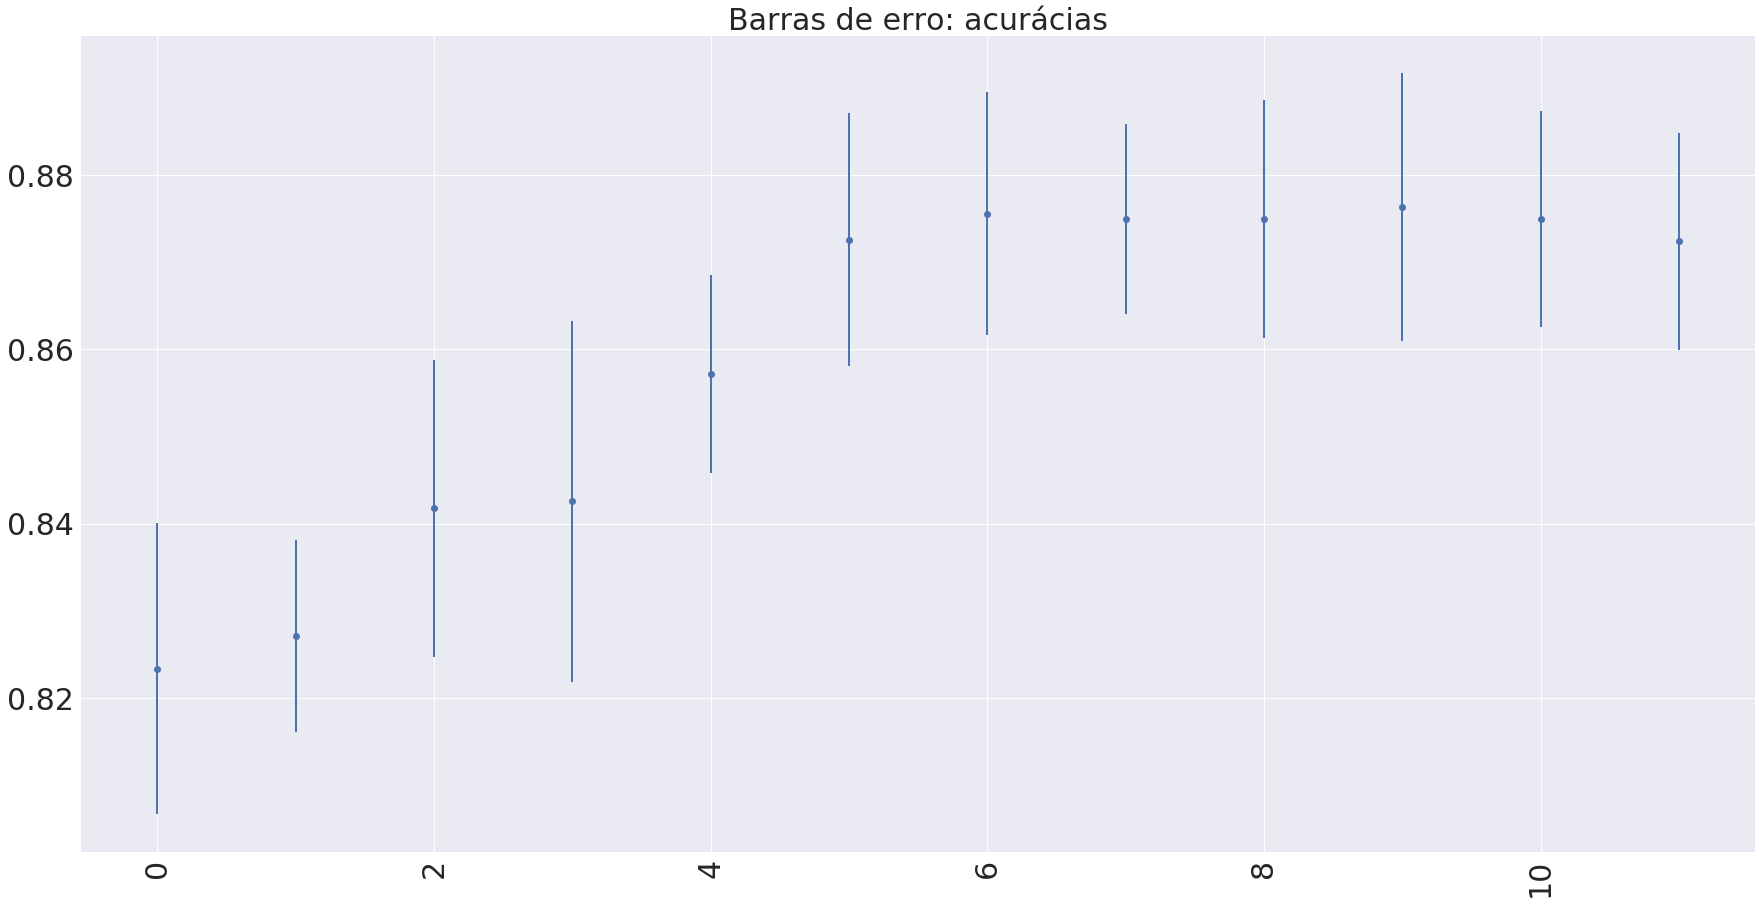

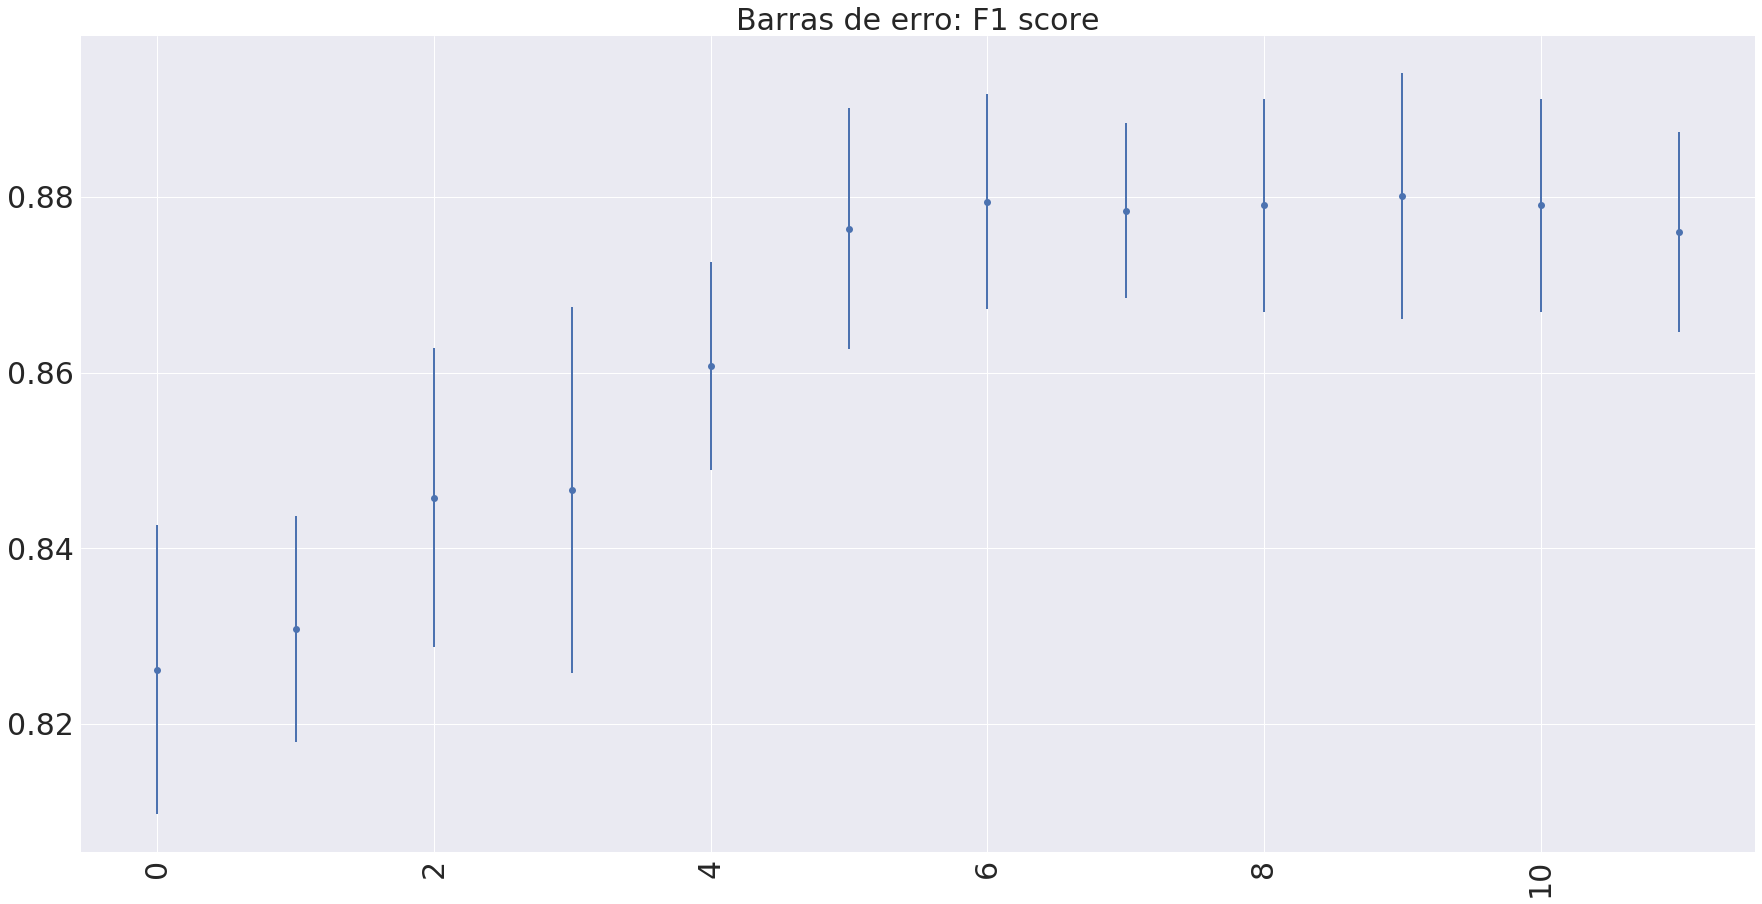

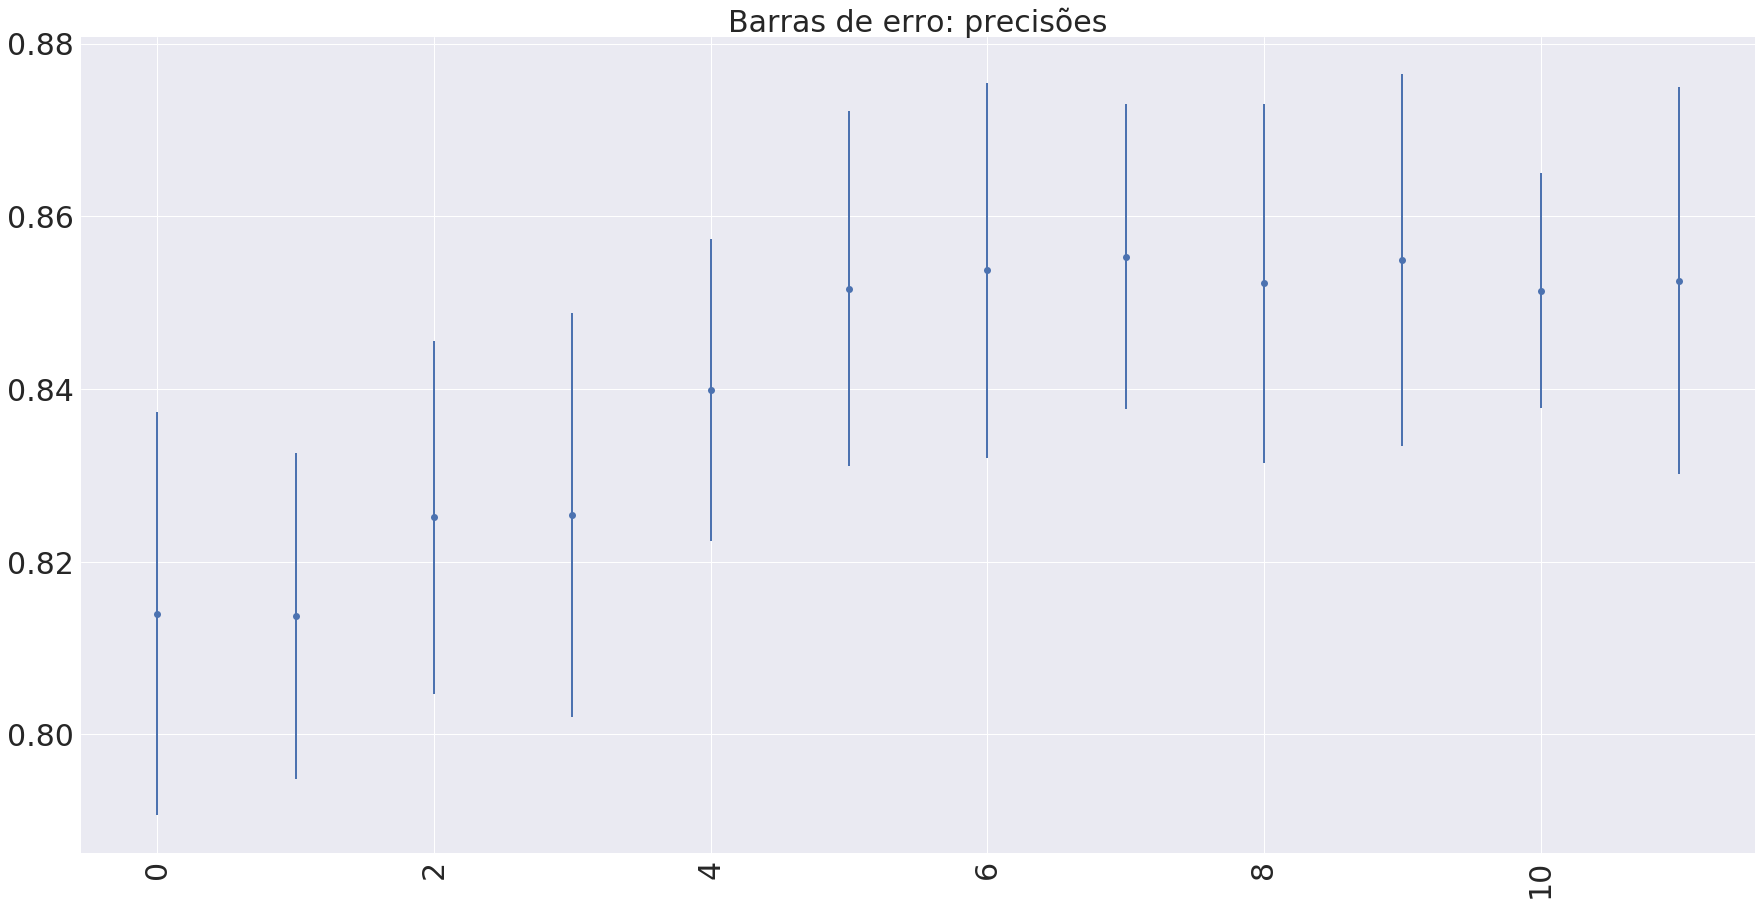

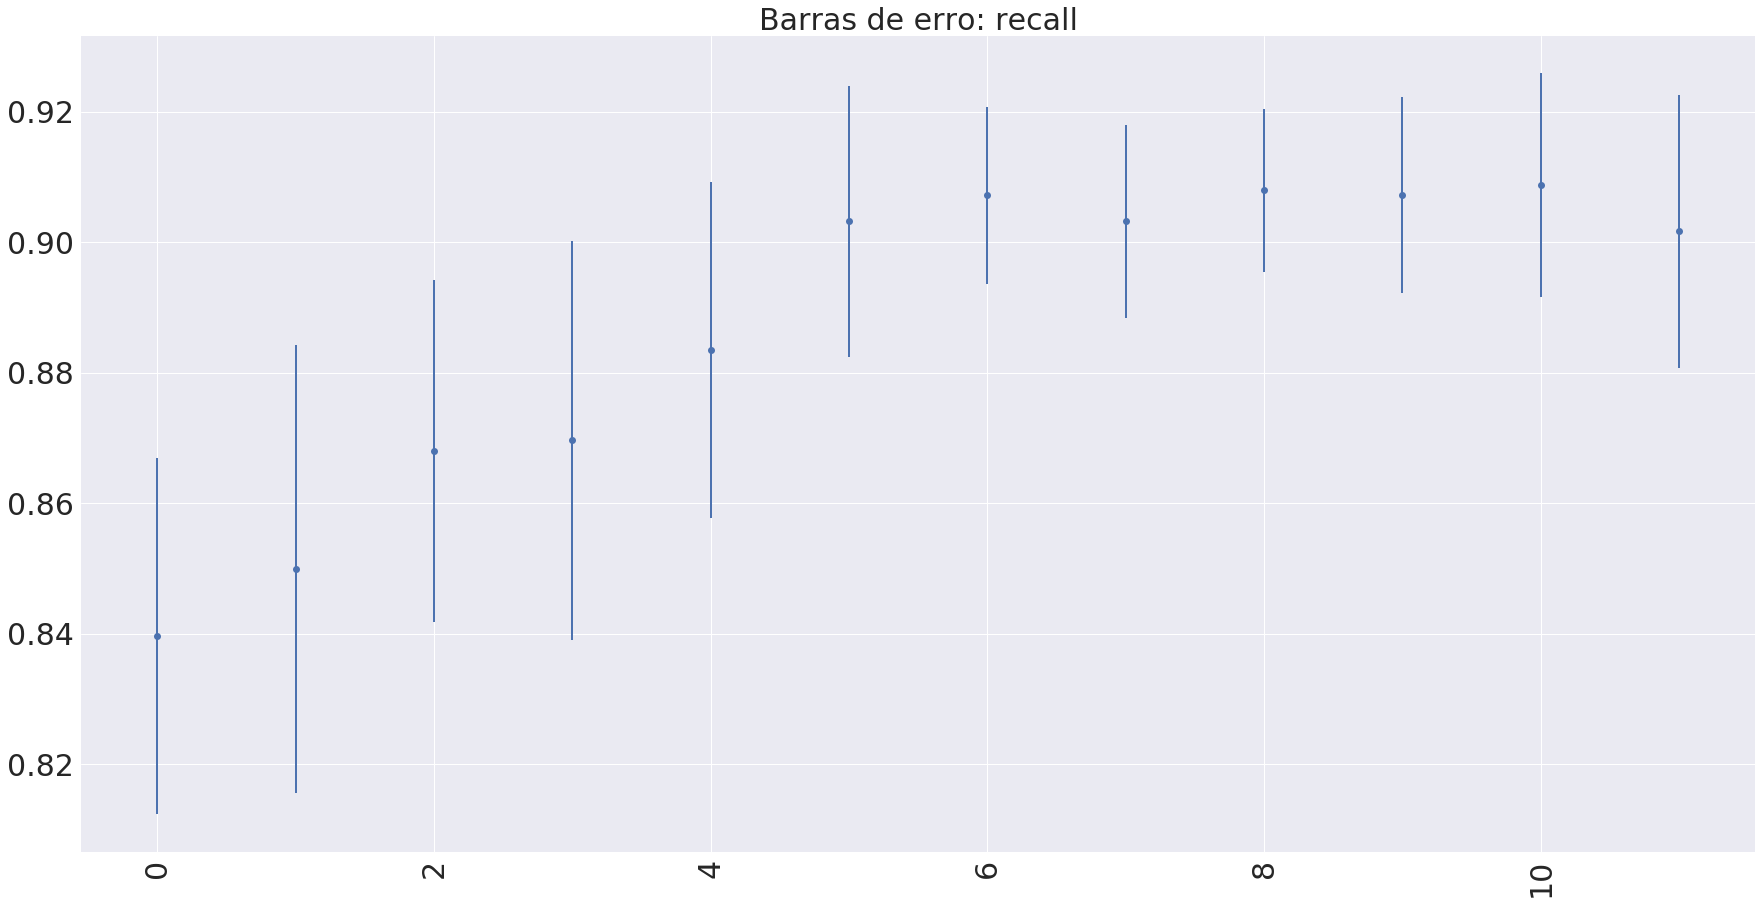

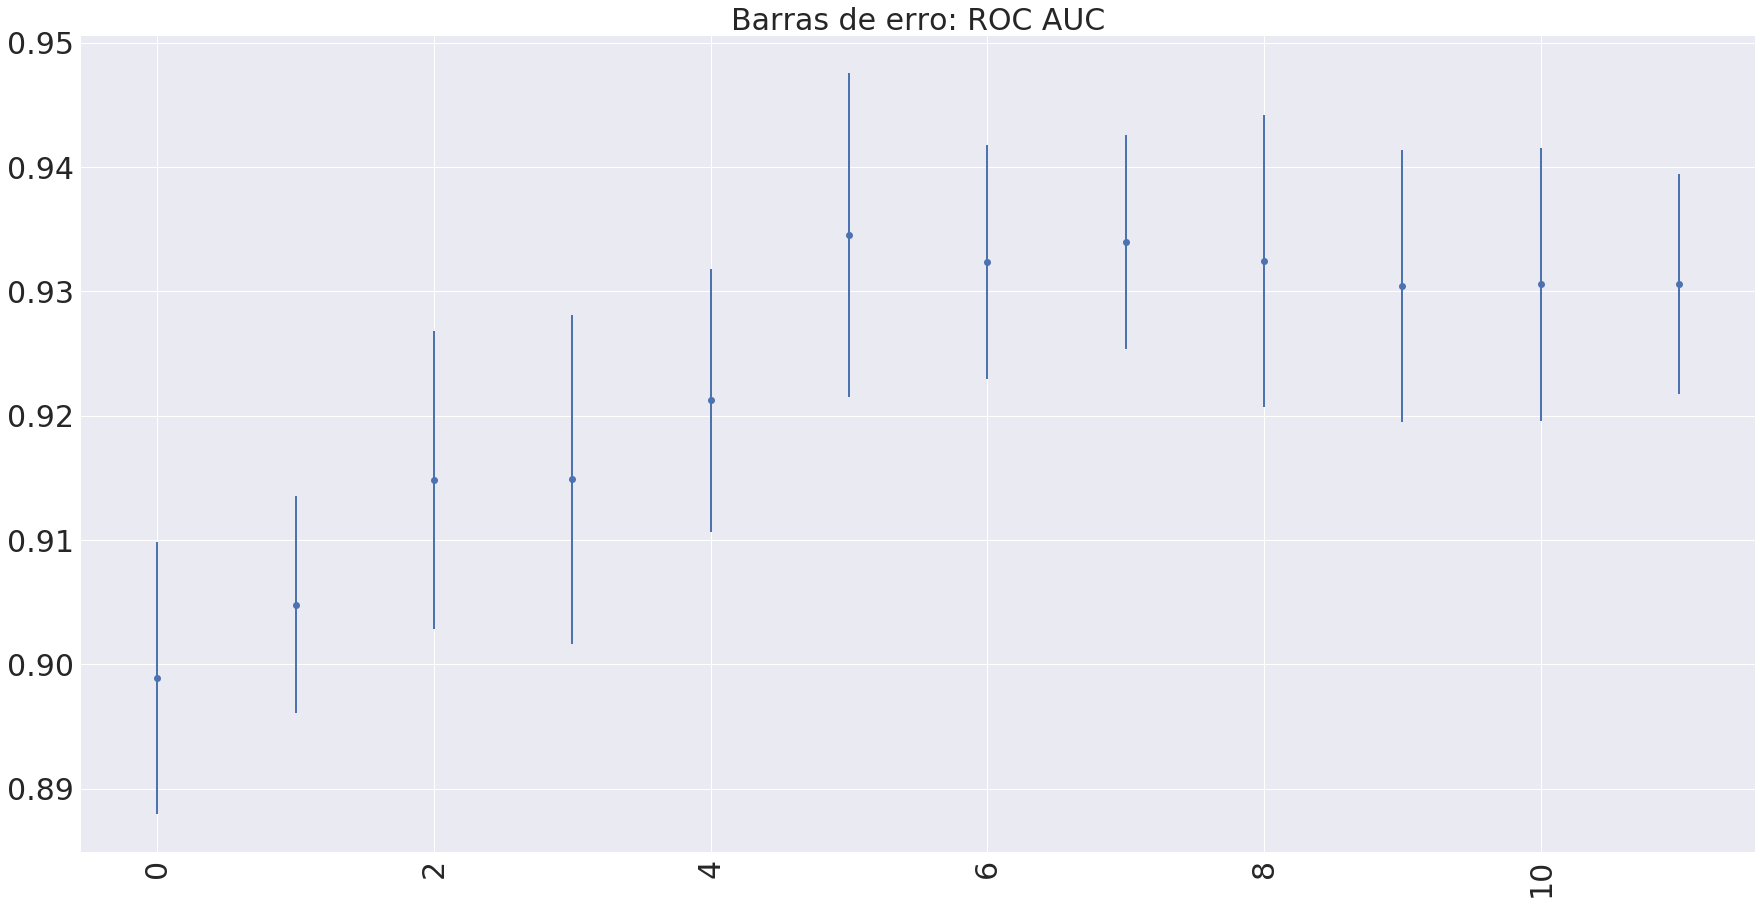

In [11]:
path_arquivos = 'Classificadores/Redes-neurais-MLP-2/teste/'
path_graficos = 'Classificadores/Redes-neurais-MLP-2/teste/graficos/'
str_balanceamento='balanceado'
param = 'param_n_neuronios'

results = joblib.load(path_arquivos+'mlp-one-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.pkl')
# display(results)
results.sort_values(by=[param], axis=0, inplace=True)

results_test = results.loc[:, 'split0_train_accuracy':'split9_test_roc_auc']
# display(results_test)
results_train = results_test.filter(regex=(".*train.*"))
results_test.drop(columns=results_train.columns,inplace=True)

lista_metricas = [('accuracy', 'acurácias'), ('f1', 'F1 score'), ('precision', 'precisões'), ('recall', 'recall'), ('roc_auc', 'ROC AUC')]

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_'+str(metrica[0])).transpose()
    
#     display(results_test_filtered)

    fig = plt.figure(figsize=(30,15))

    plt.errorbar(np.arange(0,len(results_test_filtered.columns)), results_test_filtered.mean(), yerr=results_test_filtered.std(), fmt='o', lw=2)
    plt.title('Barras de erro: ' + metrica[1], fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.yticks(fontsize=30)
    
#     filename_graficos = 'mlp-one-abordagem-2-'+str_balanceamento+'-erros-'+str(metrica[0])+'.png'
#     plt.savefig(path_graficos+filename_graficos)
    
    plt.show()

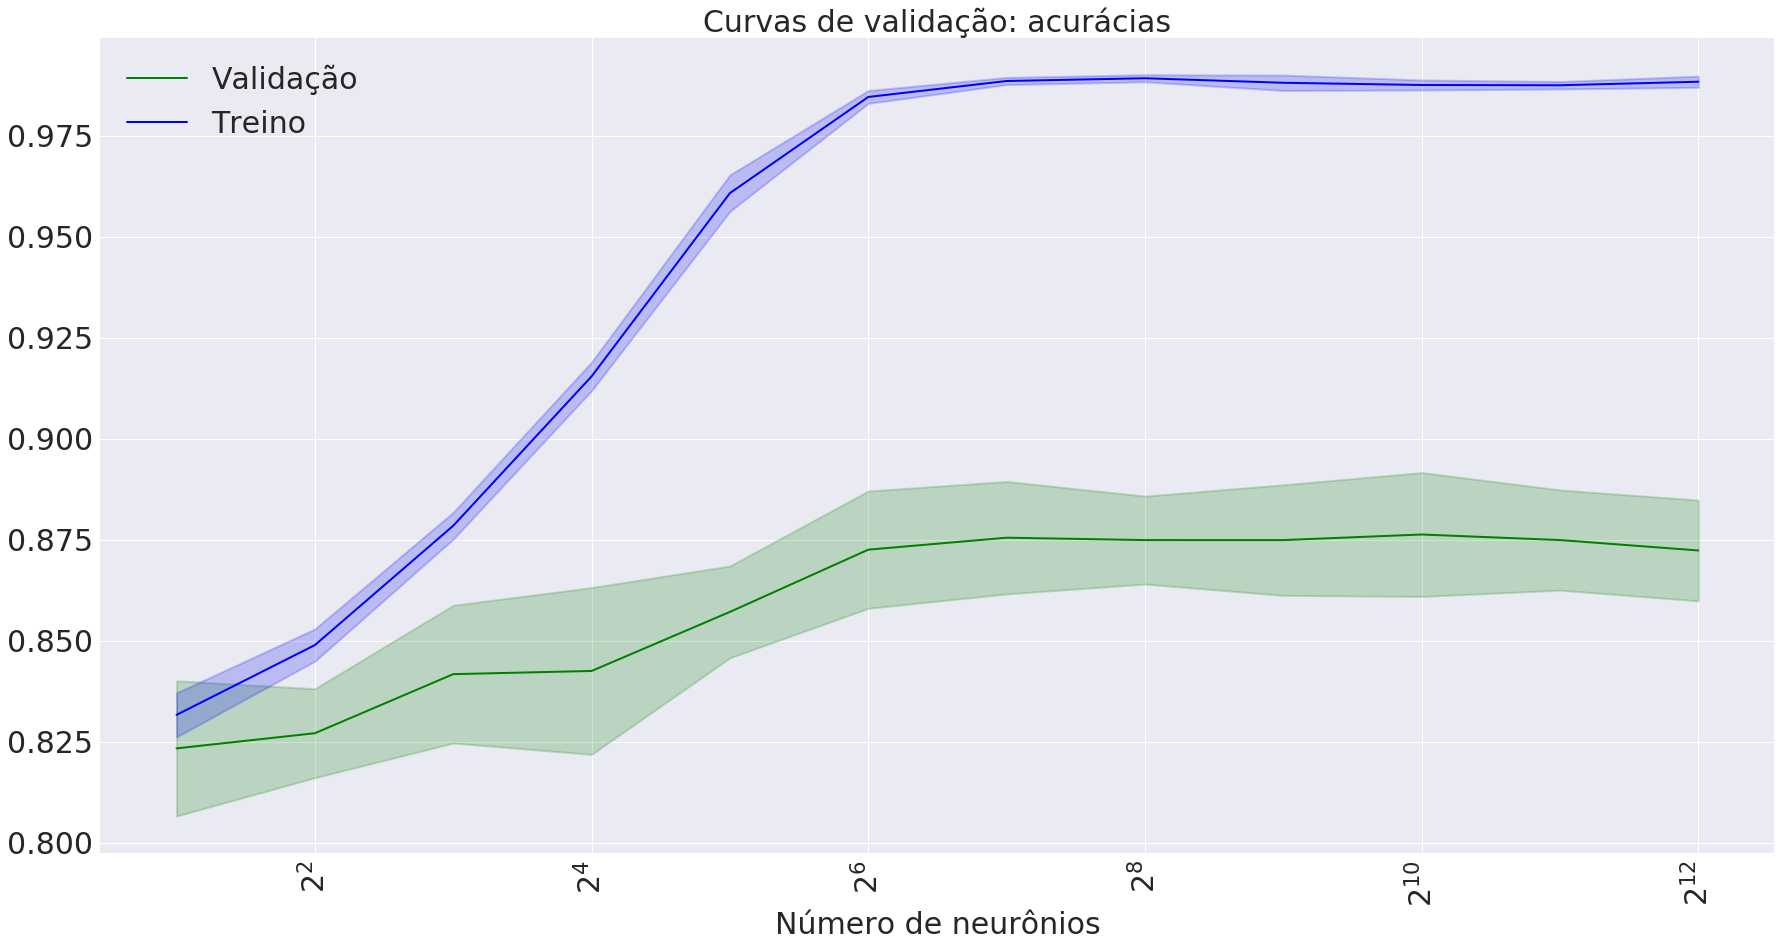

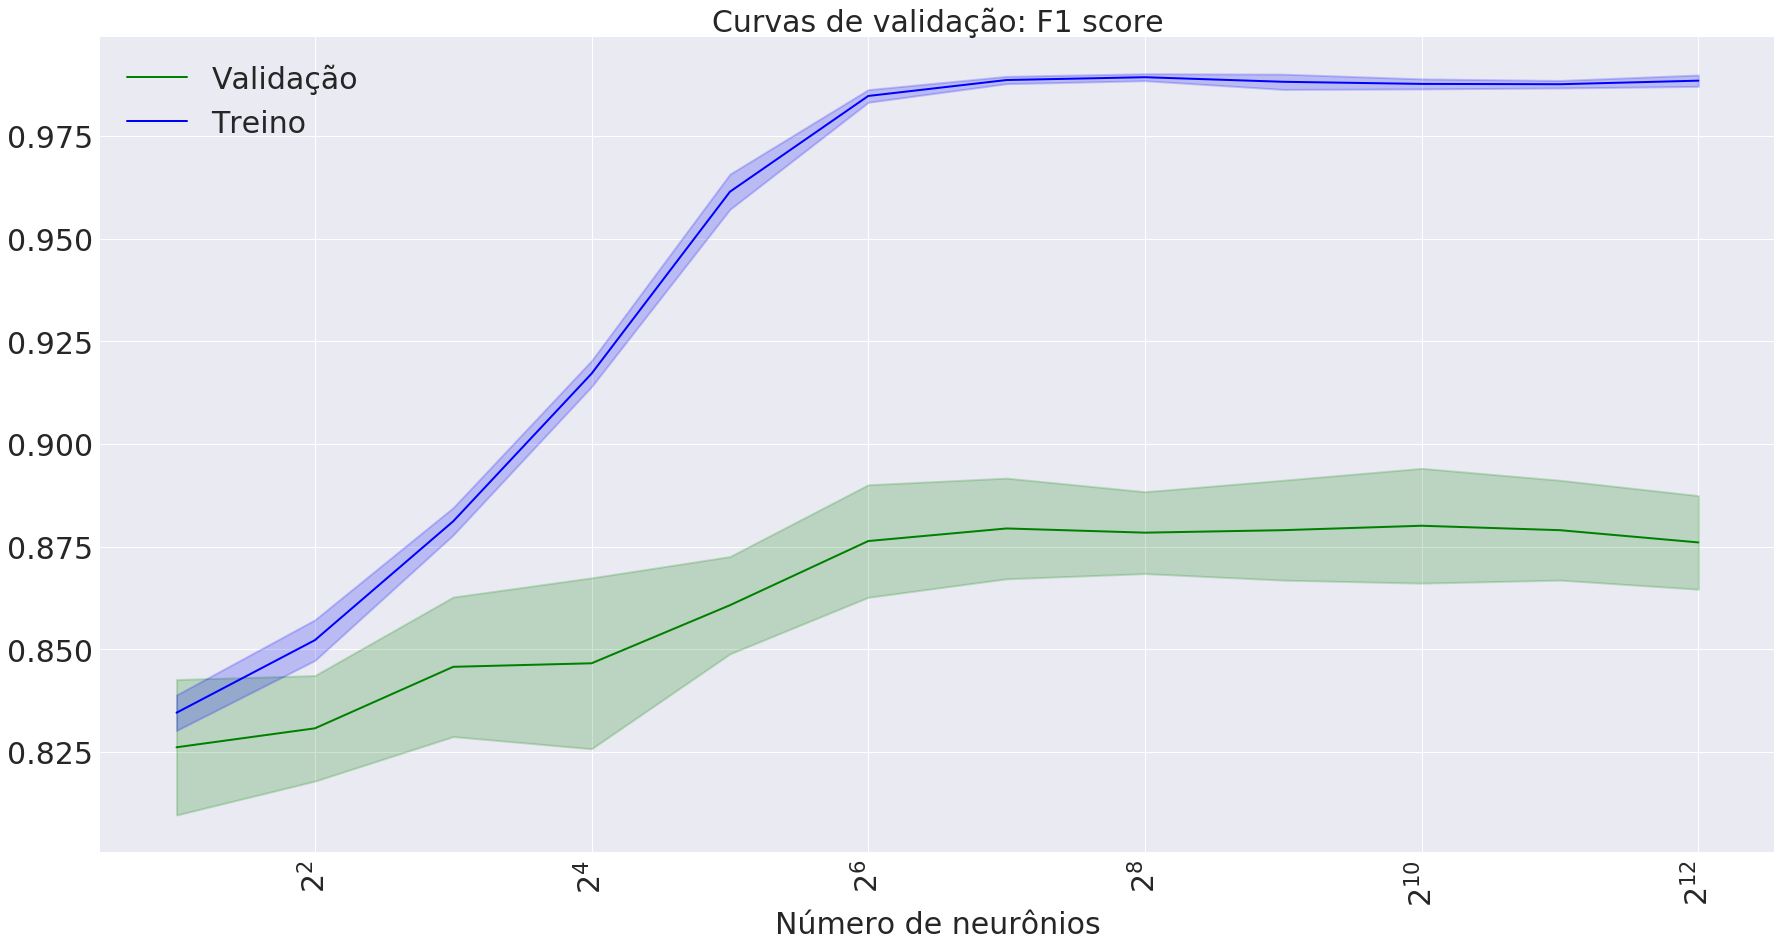

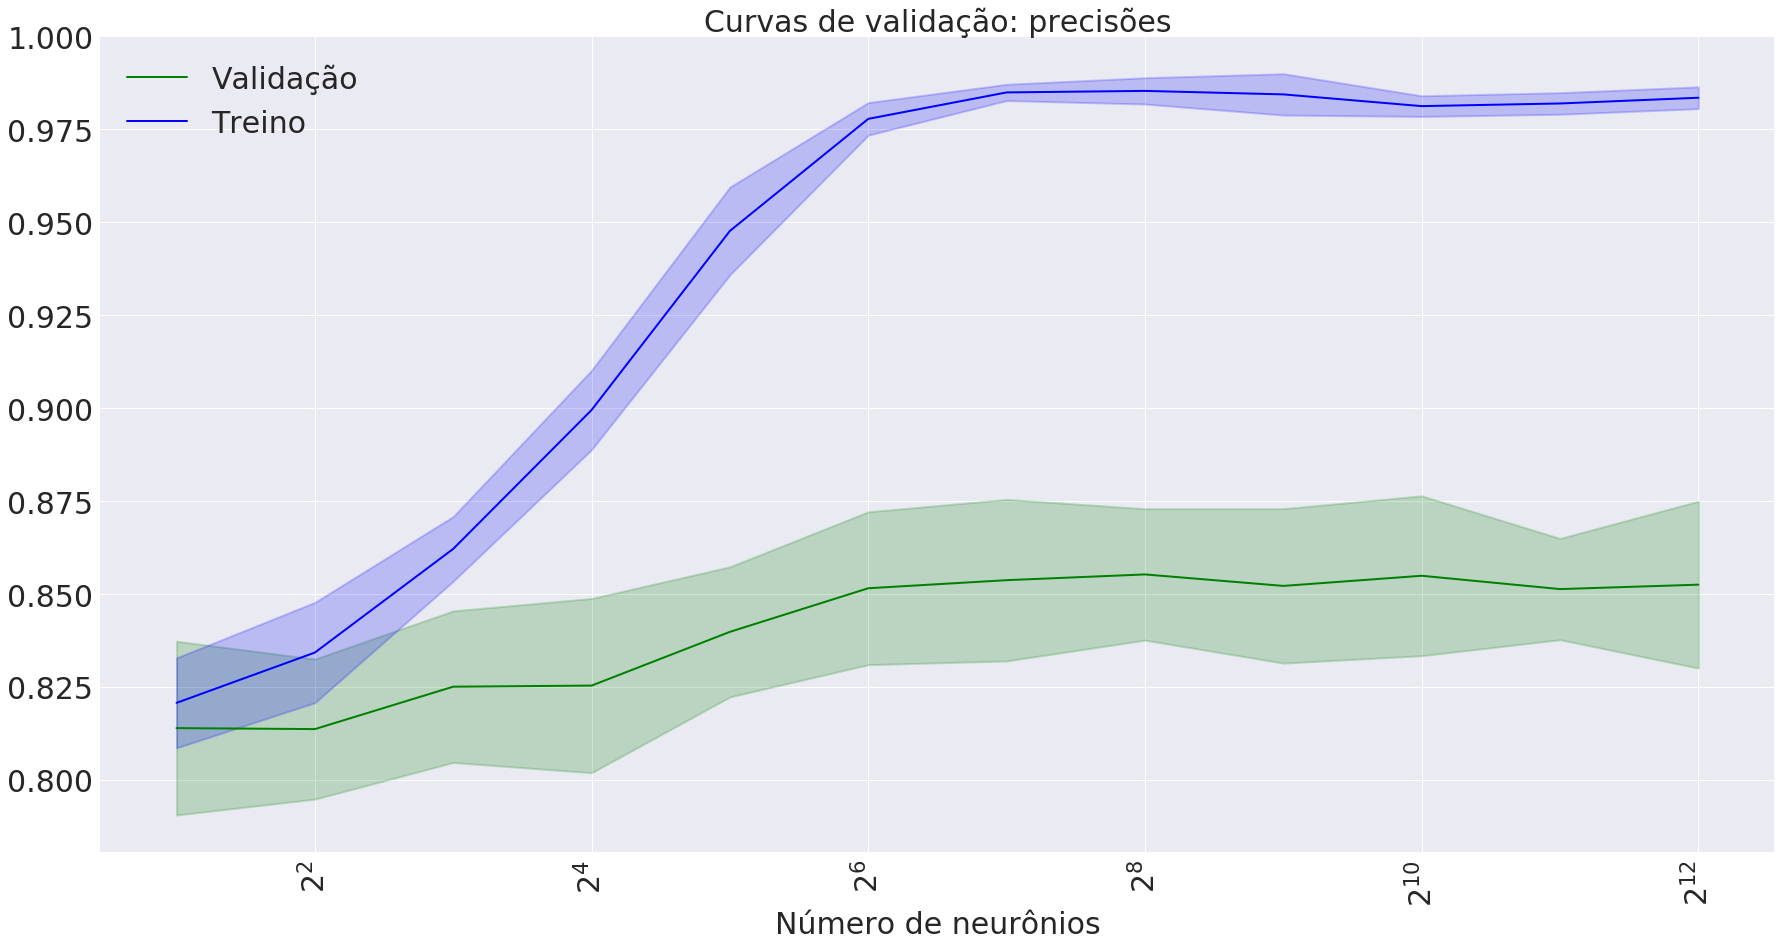

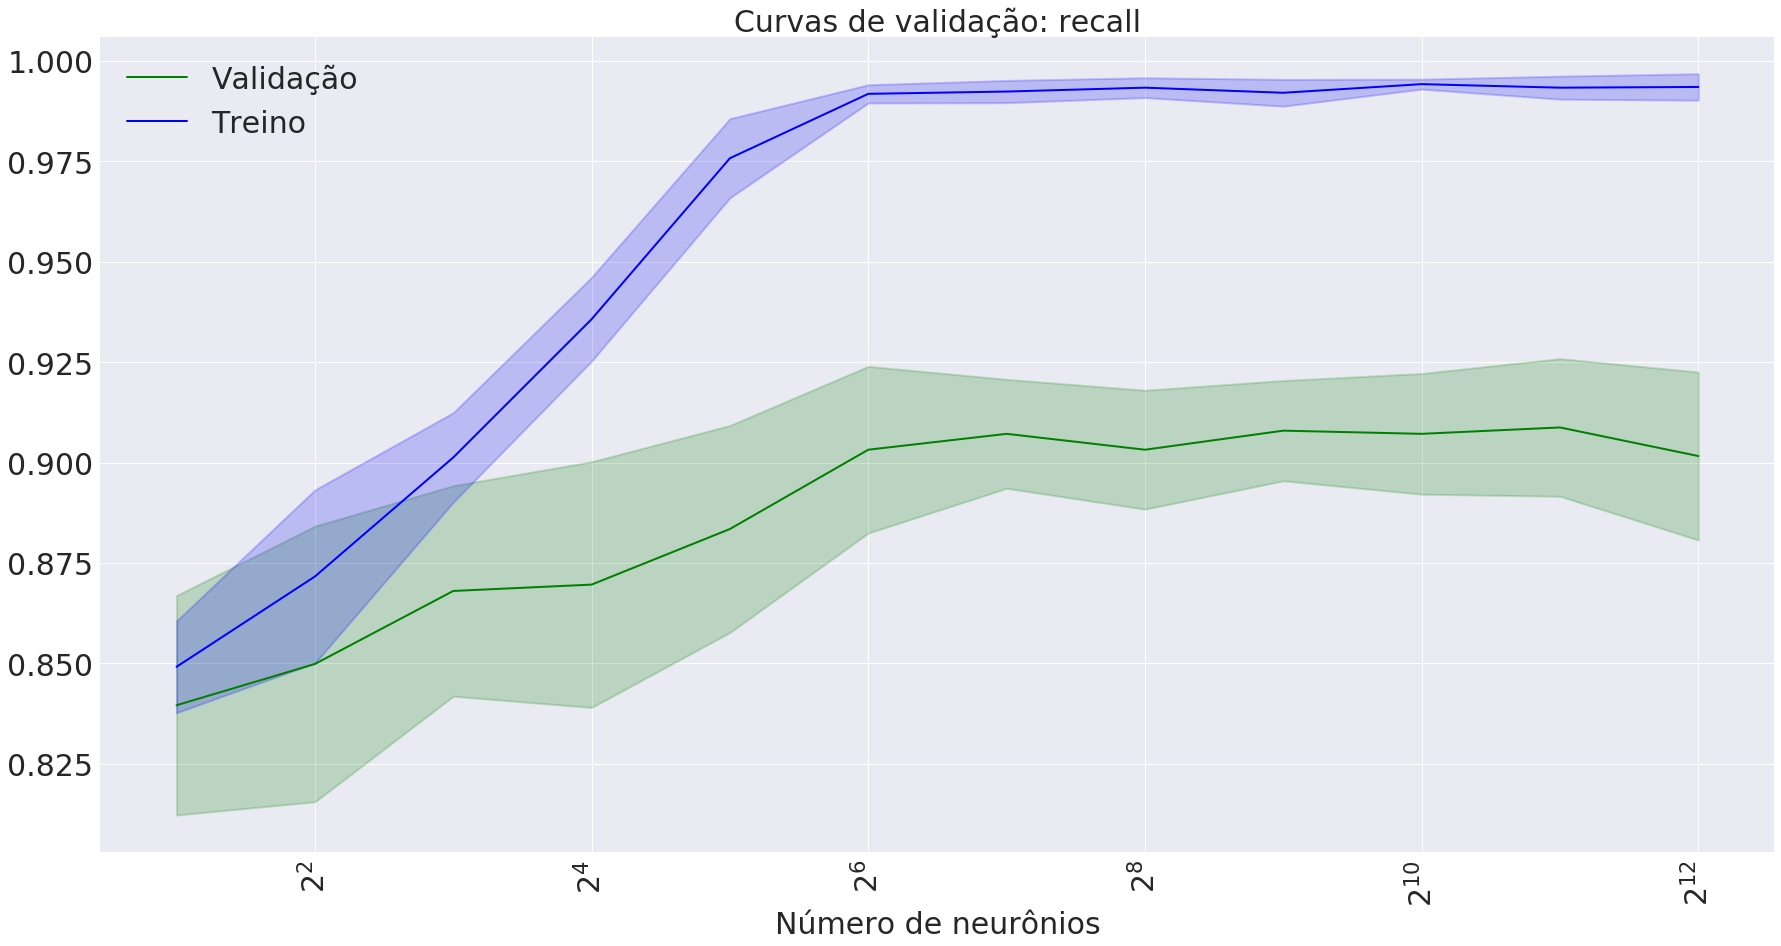

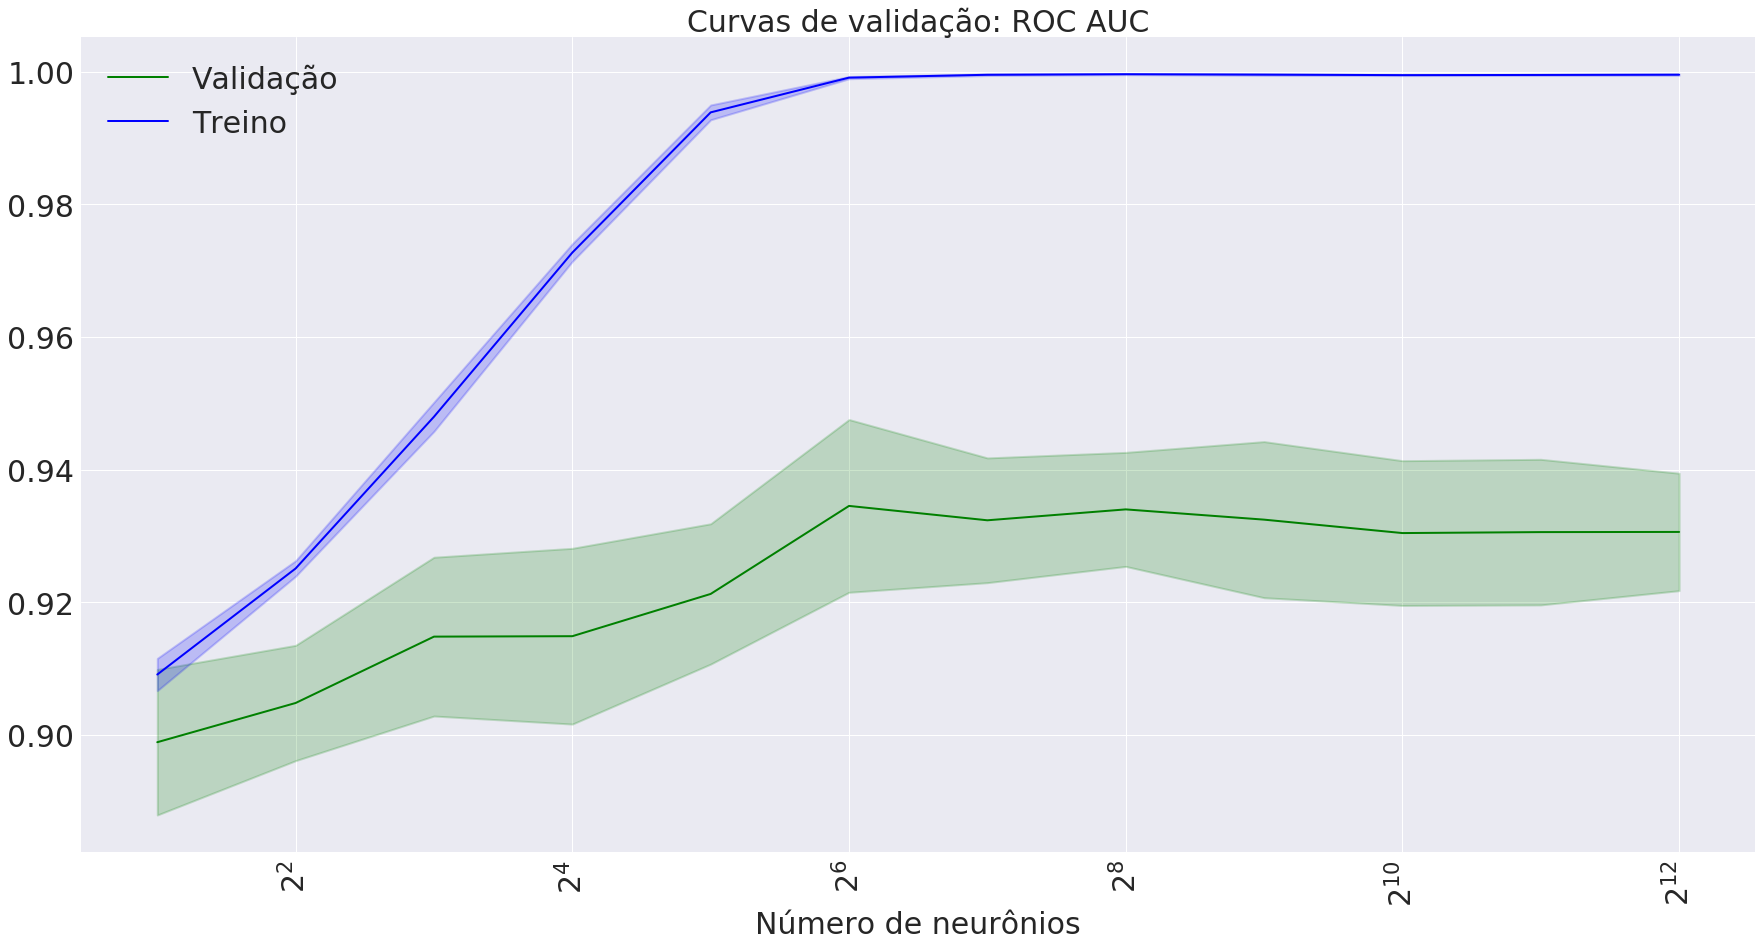

In [12]:
variable_param = 'param_n_neuronios'
variable_param_num_values = 12 
variable_param_exp_start_value = 1 
variable_param_exp_end_value = 12
variable_param_base = 2
variable_param_values = np.logspace(start=variable_param_exp_start_value,stop=variable_param_exp_end_value,
                                    num=variable_param_num_values,base=variable_param_base)

for metrica in lista_metricas:

    results_test_filtered = results_test.filter(regex='.*_test_' + str(metrica[0])).transpose()
    results_train_filtered = results_train.filter(regex='.*_train_' + str(metrica[0])).transpose()

    fig = plt.figure(figsize=(30,15))
    plt.semilogx(variable_param_values, results_test_filtered.mean(), 
                 label='Validação', color='green', lw=2, basex=variable_param_base)

    plt.fill_between(variable_param_values, results_test_filtered.mean() - results_test_filtered.std(),
                 results_test_filtered.mean() + results_test_filtered.std(), alpha=0.2, color='green', lw=2)

    plt.semilogx(variable_param_values, results_train_filtered.mean(), 
                 label='Treino', color='blue', lw=2, basex=variable_param_base)

    plt.fill_between(variable_param_values, results_train_filtered.mean() - results_train_filtered.std(),
                 results_train_filtered.mean() + results_train_filtered.std(), alpha=0.2, color='blue', lw=2)

    plot_title = 'Curvas de validação: ' + metrica[1]
    plot_xlabel = 'Número de neurônios'

    plt.title(plot_title, fontsize=30)
    plt.xticks(fontsize=30, rotation=90)
    plt.xlabel(plot_xlabel, fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(loc='best', fontsize=30)

#     filename_graficos = 'mlp-one-abordagem-2-'+str_balanceamento+'-curvas_validacao-'+variable_param+'-'+str(metrica[0])+'.png'
#     plt.savefig(path_graficos+filename_graficos)

    plt.show()

In [13]:
# Treinando o classificador final

path_arquivos = 'Classificadores/Redes-neurais-MLP-2/teste/'

model = Sequential()
model.add(Dense(2**6, input_shape=(pd.get_dummies(train_data_b_2).shape[1],), activation='sigmoid'))
# model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

# Problema de classificação binária,
model.compile(optimizer='NAdam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0,write_graph=True, write_images=True)

train_target_b_2_mod = train_target_b_2.replace(-1,0)

model.fit(pd.get_dummies(train_data_b_2), train_target_b_2_mod, epochs=400, batch_size=16, callbacks=[tbCallBack], verbose=1)
model.save(path_arquivos+'mlp-one-final-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.h5')

Epoch 1/400
5062/5062 [==============================] - 1s 134us/step - loss: 0.4847 - acc: 0.7815
Epoch 2/400
5062/5062 [==============================] - 0s 83us/step - loss: 0.4160 - acc: 0.8121
Epoch 3/400
5062/5062 [==============================] - 0s 84us/step - loss: 0.4096 - acc: 0.8153
Epoch 4/400
5062/5062 [==============================] - 0s 81us/step - loss: 0.4067 - acc: 0.8165
Epoch 5/400
5062/5062 [==============================] - 0s 91us/step - loss: 0.4043 - acc: 0.8210
Epoch 6/400
5062/5062 [==============================] - 0s 86us/step - loss: 0.4021 - acc: 0.8159
Epoch 7/400
5062/5062 [==============================] - 1s 165us/step - loss: 0.3995 - acc: 0.8186
Epoch 8/400
5062/5062 [==============================] - 1s 174us/step - loss: 0.3976 - acc: 0.8230
Epoch 9/400
5062/5062 [==============================] - 1s 150us/step - loss: 0.3951 - acc: 0.8194
Epoch 10/400
5062/5062 [==============================] - 1s 129us/step - loss: 0.3923 - acc: 0.8232
Epoc

5062/5062 [==============================] - 1s 127us/step - loss: 0.2528 - acc: 0.8927
Epoch 83/400
5062/5062 [==============================] - 1s 126us/step - loss: 0.2495 - acc: 0.8943
Epoch 84/400
5062/5062 [==============================] - 1s 127us/step - loss: 0.2483 - acc: 0.8973
Epoch 85/400
5062/5062 [==============================] - 0s 85us/step - loss: 0.2477 - acc: 0.8967
Epoch 86/400
5062/5062 [==============================] - 1s 122us/step - loss: 0.2447 - acc: 0.8967
Epoch 87/400
5062/5062 [==============================] - 1s 133us/step - loss: 0.2434 - acc: 0.9006
Epoch 88/400
5062/5062 [==============================] - 0s 86us/step - loss: 0.2414 - acc: 0.9006
Epoch 89/400
5062/5062 [==============================] - 0s 80us/step - loss: 0.2409 - acc: 0.8971
Epoch 90/400
5062/5062 [==============================] - 0s 80us/step - loss: 0.2382 - acc: 0.9012
Epoch 91/400
5062/5062 [==============================] - 0s 79us/step - loss: 0.2366 - acc: 0.9010
Epoch 92

5062/5062 [==============================] - 1s 130us/step - loss: 0.1499 - acc: 0.9439
Epoch 164/400
5062/5062 [==============================] - 1s 120us/step - loss: 0.1489 - acc: 0.9423
Epoch 165/400
5062/5062 [==============================] - 1s 105us/step - loss: 0.1489 - acc: 0.9437
Epoch 166/400
5062/5062 [==============================] - 0s 85us/step - loss: 0.1475 - acc: 0.9443
Epoch 167/400
5062/5062 [==============================] - 0s 90us/step - loss: 0.1480 - acc: 0.9437
Epoch 168/400
5062/5062 [==============================] - 0s 97us/step - loss: 0.1457 - acc: 0.9437
Epoch 169/400
5062/5062 [==============================] - 0s 85us/step - loss: 0.1455 - acc: 0.9441
Epoch 170/400
5062/5062 [==============================] - 0s 86us/step - loss: 0.1443 - acc: 0.9453
Epoch 171/400
5062/5062 [==============================] - 0s 84us/step - loss: 0.1438 - acc: 0.9443
Epoch 172/400
5062/5062 [==============================] - 0s 79us/step - loss: 0.1435 - acc: 0.9471
E

Epoch 244/400
5062/5062 [==============================] - 0s 79us/step - loss: 0.0991 - acc: 0.9637
Epoch 245/400
5062/5062 [==============================] - 0s 88us/step - loss: 0.0991 - acc: 0.9642
Epoch 246/400
5062/5062 [==============================] - 0s 78us/step - loss: 0.0999 - acc: 0.9646
Epoch 247/400
5062/5062 [==============================] - 0s 83us/step - loss: 0.0976 - acc: 0.9644
Epoch 248/400
5062/5062 [==============================] - 0s 79us/step - loss: 0.0985 - acc: 0.9621
Epoch 249/400
5062/5062 [==============================] - 0s 80us/step - loss: 0.0971 - acc: 0.9625
Epoch 250/400
5062/5062 [==============================] - 0s 80us/step - loss: 0.0966 - acc: 0.9615
Epoch 251/400
5062/5062 [==============================] - 1s 116us/step - loss: 0.0964 - acc: 0.9656
Epoch 252/400
5062/5062 [==============================] - 1s 113us/step - loss: 0.0965 - acc: 0.9658
Epoch 253/400
5062/5062 [==============================] - 0s 86us/step - loss: 0.0952 - 

5062/5062 [==============================] - 0s 62us/step - loss: 0.0715 - acc: 0.9757
Epoch 325/400
5062/5062 [==============================] - 0s 62us/step - loss: 0.0708 - acc: 0.9737
Epoch 326/400
5062/5062 [==============================] - 0s 61us/step - loss: 0.0709 - acc: 0.9749
Epoch 327/400
5062/5062 [==============================] - 0s 61us/step - loss: 0.0704 - acc: 0.9759
Epoch 328/400
5062/5062 [==============================] - 0s 61us/step - loss: 0.0714 - acc: 0.9759
Epoch 329/400
5062/5062 [==============================] - 0s 61us/step - loss: 0.0709 - acc: 0.9759
Epoch 330/400
5062/5062 [==============================] - 0s 61us/step - loss: 0.0693 - acc: 0.9755
Epoch 331/400
5062/5062 [==============================] - 0s 61us/step - loss: 0.0690 - acc: 0.9755
Epoch 332/400
5062/5062 [==============================] - 0s 61us/step - loss: 0.0698 - acc: 0.9767
Epoch 333/400
5062/5062 [==============================] - 0s 61us/step - loss: 0.0686 - acc: 0.9751
Epoc

Acurácia: 80.645 %
Precisão: 59.048 %
Recall: 63.918 %
F1 score: 61.386139 %
ROC AUC: 85.413 %
PRC AUC: 65.657 %


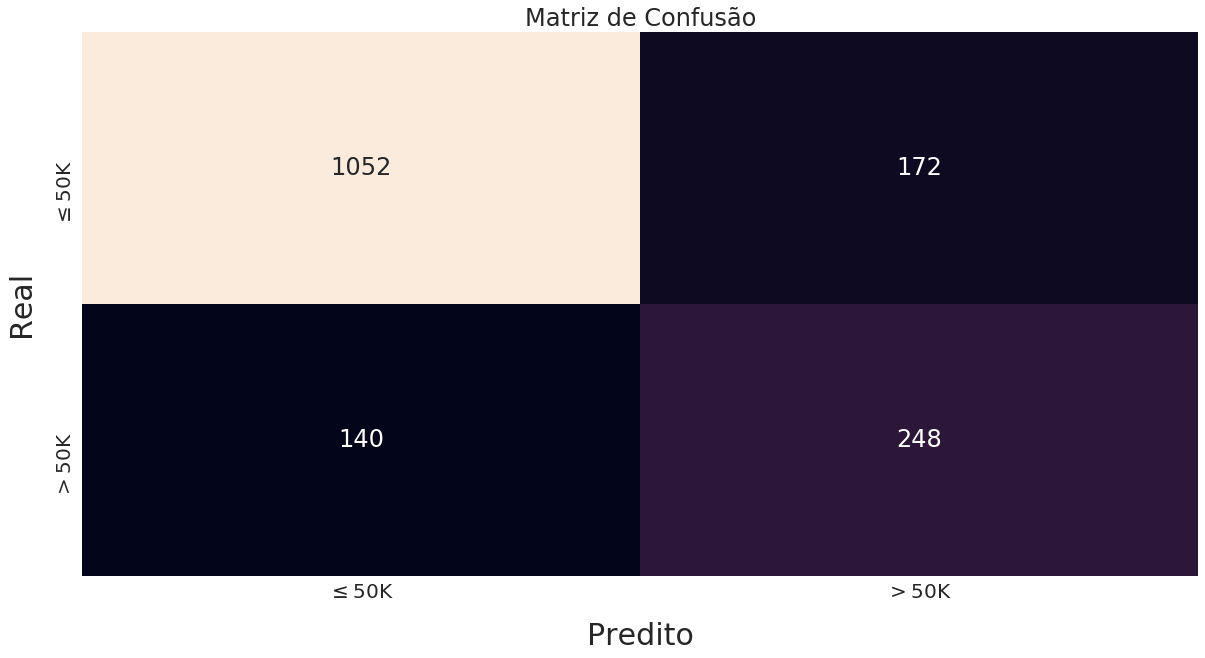

In [21]:
from keras.models import load_model

path_arquivos = 'Classificadores/Redes-neurais-MLP-2/teste/'

test_target_2_mod = test_target_2.replace(-1,0)
test_target_b_2_mod = test_target_b_2.replace(-1,0)

# display(test_target_2_mod)

mlp_one_final_balanceado = load_model(path_arquivos+'mlp-one-final-abordagem-2-balanceado-dataset-'+str(int(fracao_dataset*100))+'pct.h5')

exibir_resultados_finais(clf=mlp_one_final_balanceado, 
                         test_data=pd.get_dummies(test_data_2), 
                         test_target=test_target_2_mod, 
                         id_abordagem=2, 
                         str_balanceamento='balanceado', 
                         fracao_dataset=0.1,
                         path_arquivos=path_arquivos,
                         tipo_classificador='mlp',
                         salvar_resultados=False)

In [ ]:
# def gerarLinhaTabelaResultadosCVRedeNeural(metricas, 
#                                            n_splits,
#                                            train_scores_acc, 
#                                            train_scores_f1,
#                                            train_scores_roc,
#                                            val_scores_acc,
#                                            val_scores_f1,
#                                            val_scores_roc):

#     # Tabela com resultados de treino

#     tb_train = pd.DataFrame(columns=['split'+str(i)+'_train_'+metrica for i in list(range(0,n_splits)) for metrica in metricas])

#     idx_vetores = -1
#     for idx2,col in enumerate(tb_train.columns):
#         if idx2%3 == 0:
#             idx_vetores += 1
#             vetor = train_scores_acc
#         elif idx2%3 == 1:
#             vetor = train_scores_f1
#         elif idx2%3 == 2:
#             vetor = train_scores_roc

#         tb_train.loc[0,col] = vetor[idx_vetores]
        
# #     display(tb_train)

#     # Tabela com resultados de validação

#     tb_val = pd.DataFrame(columns=['split'+str(i)+'_test_'+metrica for i in list(range(0,n_splits)) for metrica in metricas])

#     idx_vetores = -1
#     for idx2,col in enumerate(tb_val.columns):
#         if idx2%3 == 0:
#             idx_vetores += 1
#             vetor = val_scores_acc
#         elif idx2%3 == 1:
#             vetor = val_scores_f1
#         elif idx2%3 == 2:
#             vetor = val_scores_roc

#         tb_val.loc[0,col] = vetor[idx_vetores]

#     # Concatenação das duas tabelas

#     tb = pd.concat([tb_train, tb_val], axis=1)

# #     # Adicionando as colunas com os parâmetros

# #     tb['param_n_neuronios'] = param_range
    
#     return tb, tb.values

# temp, linha = gerarLinhaTabelaResultadosCVRedeNeural(metricas, 
#                                                        n_splits_kfold,
#                                                        train_scores_acc,
#                                                        train_scores_f1,
#                                                        train_scores_roc,
#                                                        val_scores_acc,
#                                                        val_scores_f1,
#                                                        val_scores_roc)
